In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import binance_utils
import statsmodels.api as sm
from keras.models import load_model

Los datos originales se encontraban separados en cuatro archivos formato CSV. Estos archivos fueron fusionados y sus valores duplicados (sobre el 80% del total) fueron eliminados, para crear un nuevo archivo en formato PARQUET, con nombre `binance.parquet`

In [35]:
# Cargar datos:
df = pd.read_parquet('datasets/binance.parquet')

# Establecer columna 'timestamp' como índice:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# **Análisis Exploratorio de Datos**

## Validación de datos

In [36]:
# Buscar valores nulos:
null_values = df.isnull().sum()
columns_with_nulls = null_values[null_values > 0]

if not columns_with_nulls.empty:
    print(columns_with_nulls)
else:
    print("No hay valores nulos en el DataFrame.")

No hay valores nulos en el DataFrame.


In [37]:
# Verificar filas duplicadas:
duplicated_rows = df.duplicated().sum()
duplicated_pct = duplicated_rows / len(df)
print(f"Porcentaje de observaciones duplicadas: {duplicated_pct:.10%}")

Porcentaje de observaciones duplicadas: 0.0000364222%


In [38]:
# Revisar la dimensión del conjunto de datos:
print(f"El conjunto de datos tiene {df.shape[0]:,} observaciones y {df.shape[1]:,} variables.")

El conjunto de datos tiene 2,745,576 observaciones y 28 variables.


### Granularidad de los datos

En series temporales, la granularidad es el intervalo de tiempo que cada punto de datos representa. Una granularidad consistente es un elemento fundamental para el análisis y modelado de redes neuronales como las LSTM, ya que afecta de forma directa la resolución temporal, la captura de tendencias periódicas y el desempeño del modelo. Una granularidad más fina ofrece más detalle pero puede incluir más ruido y requerir más recursos computacionales, mientras que una granularidad más gruesa puede reducir el ruido pero perder detalles importantes. 
La granularidad correcta permite capturar la dinámica temporal relevante del problema que se está modelando. 

In [39]:
# Calcular las diferencias en segundos
time_diff_seconds = df.index.to_series().diff().dt.total_seconds()

# Calcular la media y desviación estándar de las diferencias
time_diff_mean_seconds = time_diff_seconds.mean()
time_diff_std_seconds = time_diff_seconds.std()
print("Granularidad media, en segundos: ", time_diff_mean_seconds)
print("Desviación estándar de la granularidad: ", time_diff_std_seconds)

Granularidad media, en segundos:  0.5032822274653643
Desviación estándar de la granularidad:  1.4036327730222053


Notamos que el conjunto de datos cuenta con una granularidad (media de 0.5 segundos) muy fina y una gran cantidad de observaciones, lo cual es beneficioso para capturar una gran cantidad de detalles en las variaciones de precio. Sin embargo, la desviación estándar es relativamente alta, por lo que es necesario mayor exploración. Vamos a revisar si existen brechas en los datos:

In [40]:
# Validar consistencia de 'timestamp':
time_diff = df.index.to_series().diff().value_counts()
time_diff

timestamp
0 days 00:00:00.500000768    406877
0 days 00:00:00.500001024    386927
0 days 00:00:00.500001280    375101
0 days 00:00:00.500001536    333432
0 days 00:00:00.500002048    310141
0 days 00:00:00.500000512    244268
0 days 00:00:00.500001792    222360
0 days 00:00:00.500002304    180051
0 days 00:00:00.500002816     99929
0 days 00:00:00.500000256     79793
0 days 00:00:00.500002560     63101
0 days 00:00:00.500003072     32115
0 days 00:00:00.500000         9791
0 days 00:00:00.500003328      1674
0 days 00:10:00.919105024         1
0 days 00:10:00.694799616         1
0 days 00:10:00.684328448         1
0 days 00:10:00.645758208         1
0 days 00:10:02.370601728         1
0 days 00:10:01.053577728         1
0 days 00:10:00.838393856         1
0 days 00:10:00.735068928         1
0 days 00:10:01.408174336         1
0 days 00:10:00.803035904         1
0 days 00:10:00.872205568         1
0 days 00:10:00.729733376         1
0 days 00:10:01.093585664         1
0 days 00:10:01.14

En las diferencias de tiempo entre observaciones, notamos 15 brechas temporales de 10 minutos. Investigamos su naturaleza:

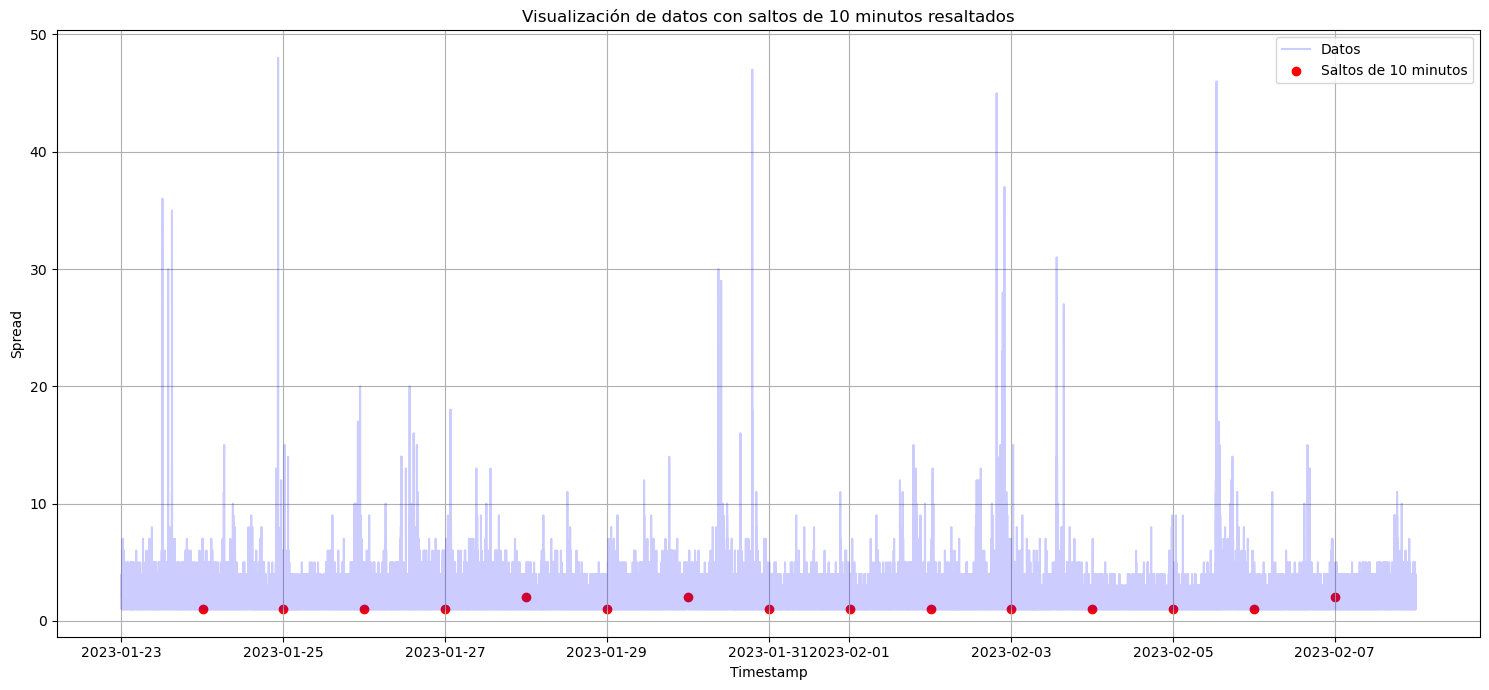

In [41]:
# Asegurarse de que los datos estén ordenados por timestamp:
df_10min = df.reset_index().sort_values(by='timestamp')

# Calcular la diferencia entre timestamps consecutivos:
df_10min['time_diff'] = df_10min['timestamp'].diff()

# Identificar los puntos de interés:
mask = df_10min['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Graficar los datos:
plt.figure(figsize=(15, 7))
plt.plot(df_10min['timestamp'], df_10min['spread'], label='Datos', color='blue', alpha=0.2)
plt.scatter(df_10min[mask]['timestamp'], df_10min[mask]['spread'], color='red', label='Saltos de 10 minutos')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.title('Visualización de datos con saltos de 10 minutos resaltados')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Calcular la diferencia entre timestamps consecutivos:
df_10min['time_diff'] = df_10min['timestamp'].diff()

# Identificar los puntos de interés:
mask = df_10min['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Crear una máscara para los puntos inmediatamente posteriores:
next_mask = mask.shift(-1, fill_value=False)

# Combinar las dos máscaras usando el operador "or":
combined_mask = mask | next_mask

# Extraer estos puntos en un nuevo DataFrame:
df_10min_timeskips = df_10min[combined_mask].copy()

df_10min_timeskips.sort_values('timestamp', ascending=True, inplace=True)
df_10min_timeskips.set_index('timestamp', inplace=True)

print("Saltos de 10 minutos detectados:\n", df_10min_timeskips.index)


Saltos de 10 minutos detectados:
 DatetimeIndex(['2023-01-23 23:54:59.459493120',
               '2023-01-24 00:05:00.602287104',
               '2023-01-24 23:54:59.469715200',
               '2023-01-25 00:05:00.563300864',
               '2023-01-25 23:54:59.934701568',
               '2023-01-26 00:05:00.664434944',
               '2023-01-26 23:54:59.788566016',
               '2023-01-27 00:05:00.626959872',
               '2023-01-27 23:54:59.901041408',
               '2023-01-28 00:05:00.773246976',
               '2023-01-28 23:54:59.843753472',
               '2023-01-29 00:05:00.646789376',
               '2023-01-29 23:54:59.372211712',
               '2023-01-30 00:05:00.780386048',
               '2023-01-30 23:54:59.890614528',
               '2023-01-31 00:05:00.625683456',
               '2023-01-31 23:54:59.606319360',
               '2023-02-01 00:05:00.659897088',
               '2023-02-01 23:54:58.416104192',
               '2023-02-02 00:05:00.786705920',
      

Los saltos temporales de 10 minutos ocurren cada vez entre las `23:55:00` y las `00:05:00`, lo que nos sugiere fuertemente que nos brechas surgidas de forma aleatoria. Esto puede tratarse a cierres temporales programados en el sistema de recolección de datos, probablemente para mantenimiento. Sin embargo, notaremos que estas brechas no representarán un problema para la predicción de valores  del lapso de tiempo escogido de 5 minutos.

Para asegurarnos de que la granularidad es consistente a lo largo del conjunto de datos, revisaremos si esta es consistente a lo largo de cada hora de cada día del conjunto de datos. Para esto, utilizaremos un mapa de calor.

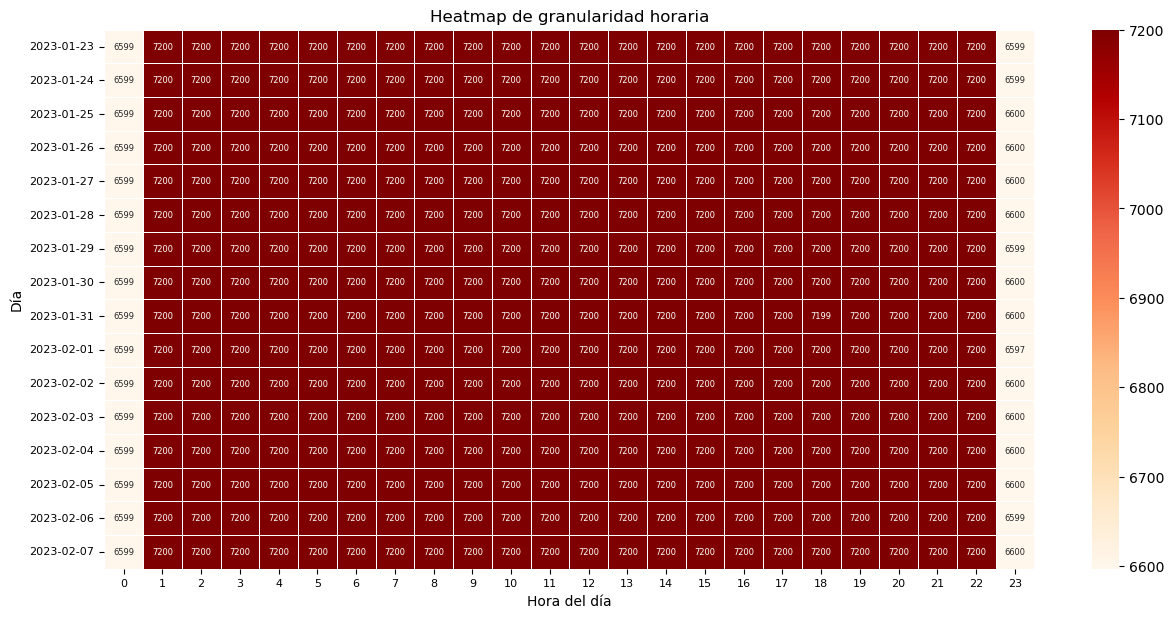

In [43]:
# Remuestrear los datos por hora y cuenta el número de registros por hora
df_resampled = df.resample('H').size().reset_index(name='count')
df_resampled.columns = ['timestamp', 'count']

# Extraer el día y la hora de la columna 'timestamp'
df_resampled['day'] = df_resampled['timestamp'].dt.date
df_resampled['hour'] = df_resampled['timestamp'].dt.hour

# Crear una tabla pivote para el heatmap
heatmap_data = df_resampled.pivot(index='day', columns='hour', values='count')

# Dibujar el heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(heatmap_data, cmap='OrRd', linewidths=0.5, annot=True, fmt=".0f", annot_kws={"size": 6})  # Ajusta el tamaño con "size"
plt.title('Heatmap de granularidad horaria')
plt.xticks(size=8)
plt.yticks(size=8)
plt.ylabel('Día')
plt.xlabel('Hora del día')
plt.show()

La temperatura de los recuadros representa la cantidad de observaciones contenidas en cada hora (eje horizontal), de cada día (eje vertical), a lo largo del dataset. Visualizamos una distribución homogénea de observaciones, consistente con la granularidad media de 0.5 segundos, 7200 observaciones por hora.

Los recuadros de color claro indican menor cantidad de datos por hora, aunque estos también son consistentes y a los 10 minutos de posible cierre del sistema de recolección de datos, a medianoche todos los días.

## Visualización de los datos originales

### Correlaciones no lineales

LA **correlación de Spearman** es una medida de la relación monótona entre dos variables. Varía entre -1 y +1 con interpretación similar a la correlación de Pearson, aunque la primera no se limita a relaciones lineales. Una correlación de Spearman de +1 (-1) indica que cada vez que una variable aumenta (disminuye), la otra también lo hace, aunque no necesariamente a una tasa constante.

A diferencia de Pearson, la correlación de Spearman es menos sensible a outliers debido a que se basa en los rangos de los datos en lugar de en los valores de los datos. También, la correlación de Spearman es más apropiada para relaciones monótonas no lineales y/o cuando los datos no están normalmente distribuidos. Por esta motivo, la correlación de Spearman es un método más robusto para medir la correlación de un conjunto de datos como el utilizado.

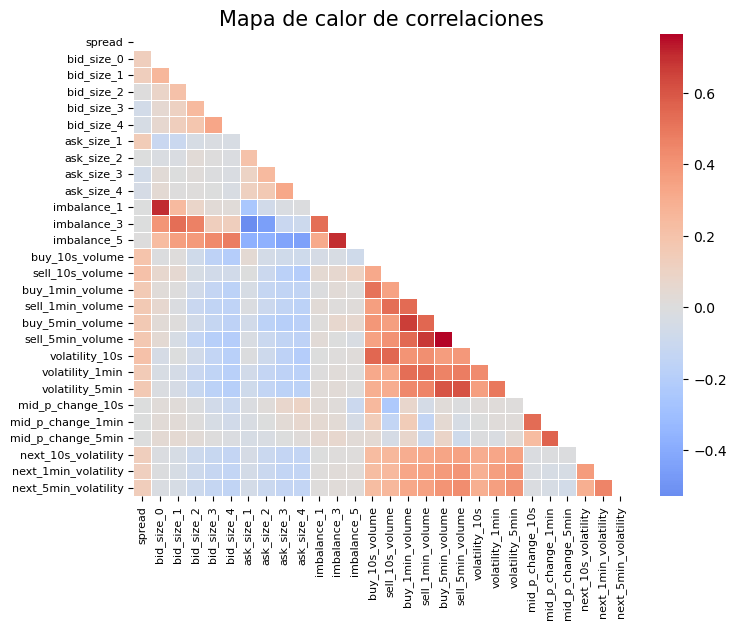

In [44]:
# Mapa de calor
corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=False)
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig('images/corr-heatmap.png', dpi='figure')
plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/corr-heatmap.png')
# plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

### Distribución de las variables

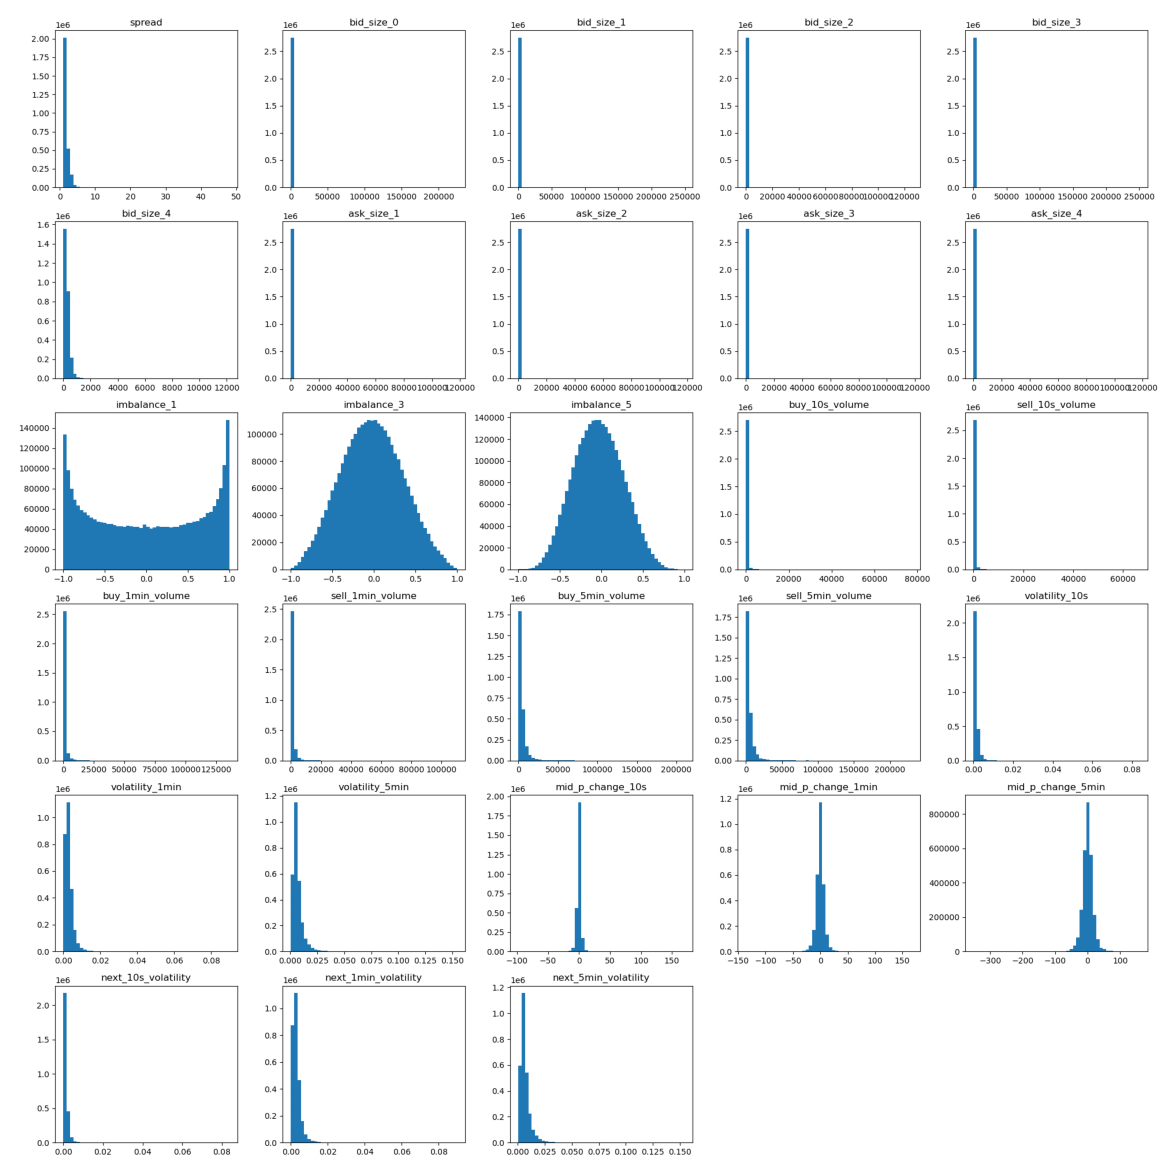

In [45]:
# # Plotear histogramas de cada variable:
# df.hist(figsize=(20, 20), bins=50, grid=False)
# plt.tight_layout()
# plt.savefig('images/var-histograms.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/var-histograms.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis('off')
plt.show()

En los histogramas de cada una de las variables originales, notamos que casi ninguna tiene una distribución normal: la mayoría tiene una forma leptocúrtica, lo cual sugiere que la mayor cantidad de observaciones se concentra alrededor de su media. 

### Boxplots

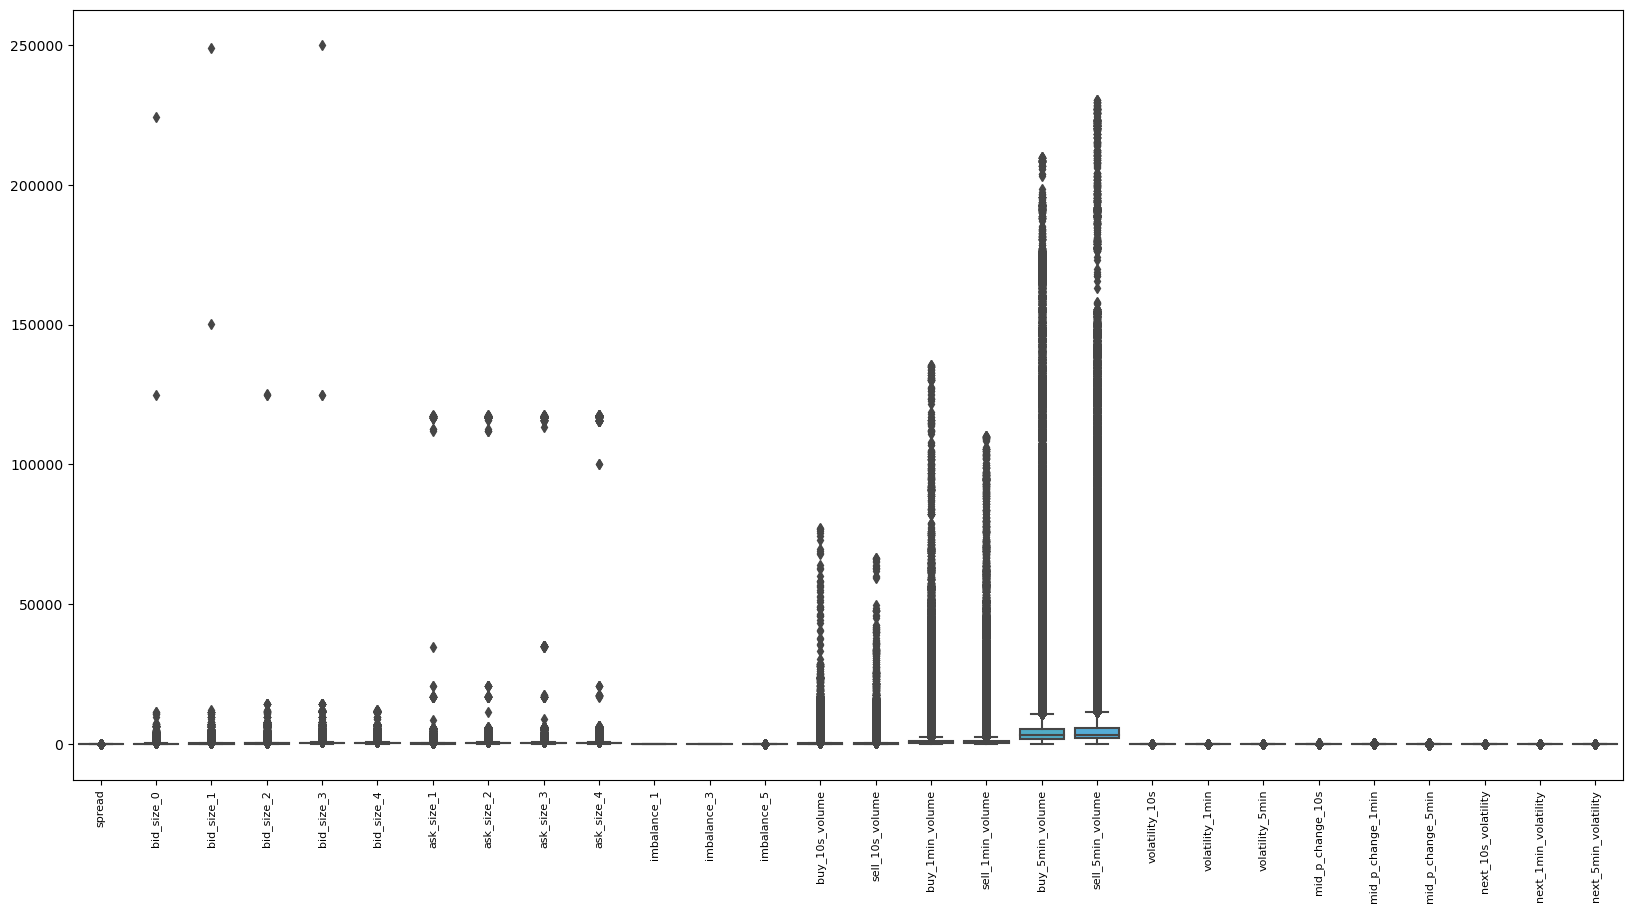

In [46]:
# Boxplots
plt.figure(figsize=(20, 10))
sns.boxplot(df)
plt.xticks(fontsize=8, rotation=90)
plt.savefig('images/var-boxplots.png', dpi='figure')
plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/var-boxplots.png')
# plt.figure(figsize=(15,10))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

### Gráficos de líneas

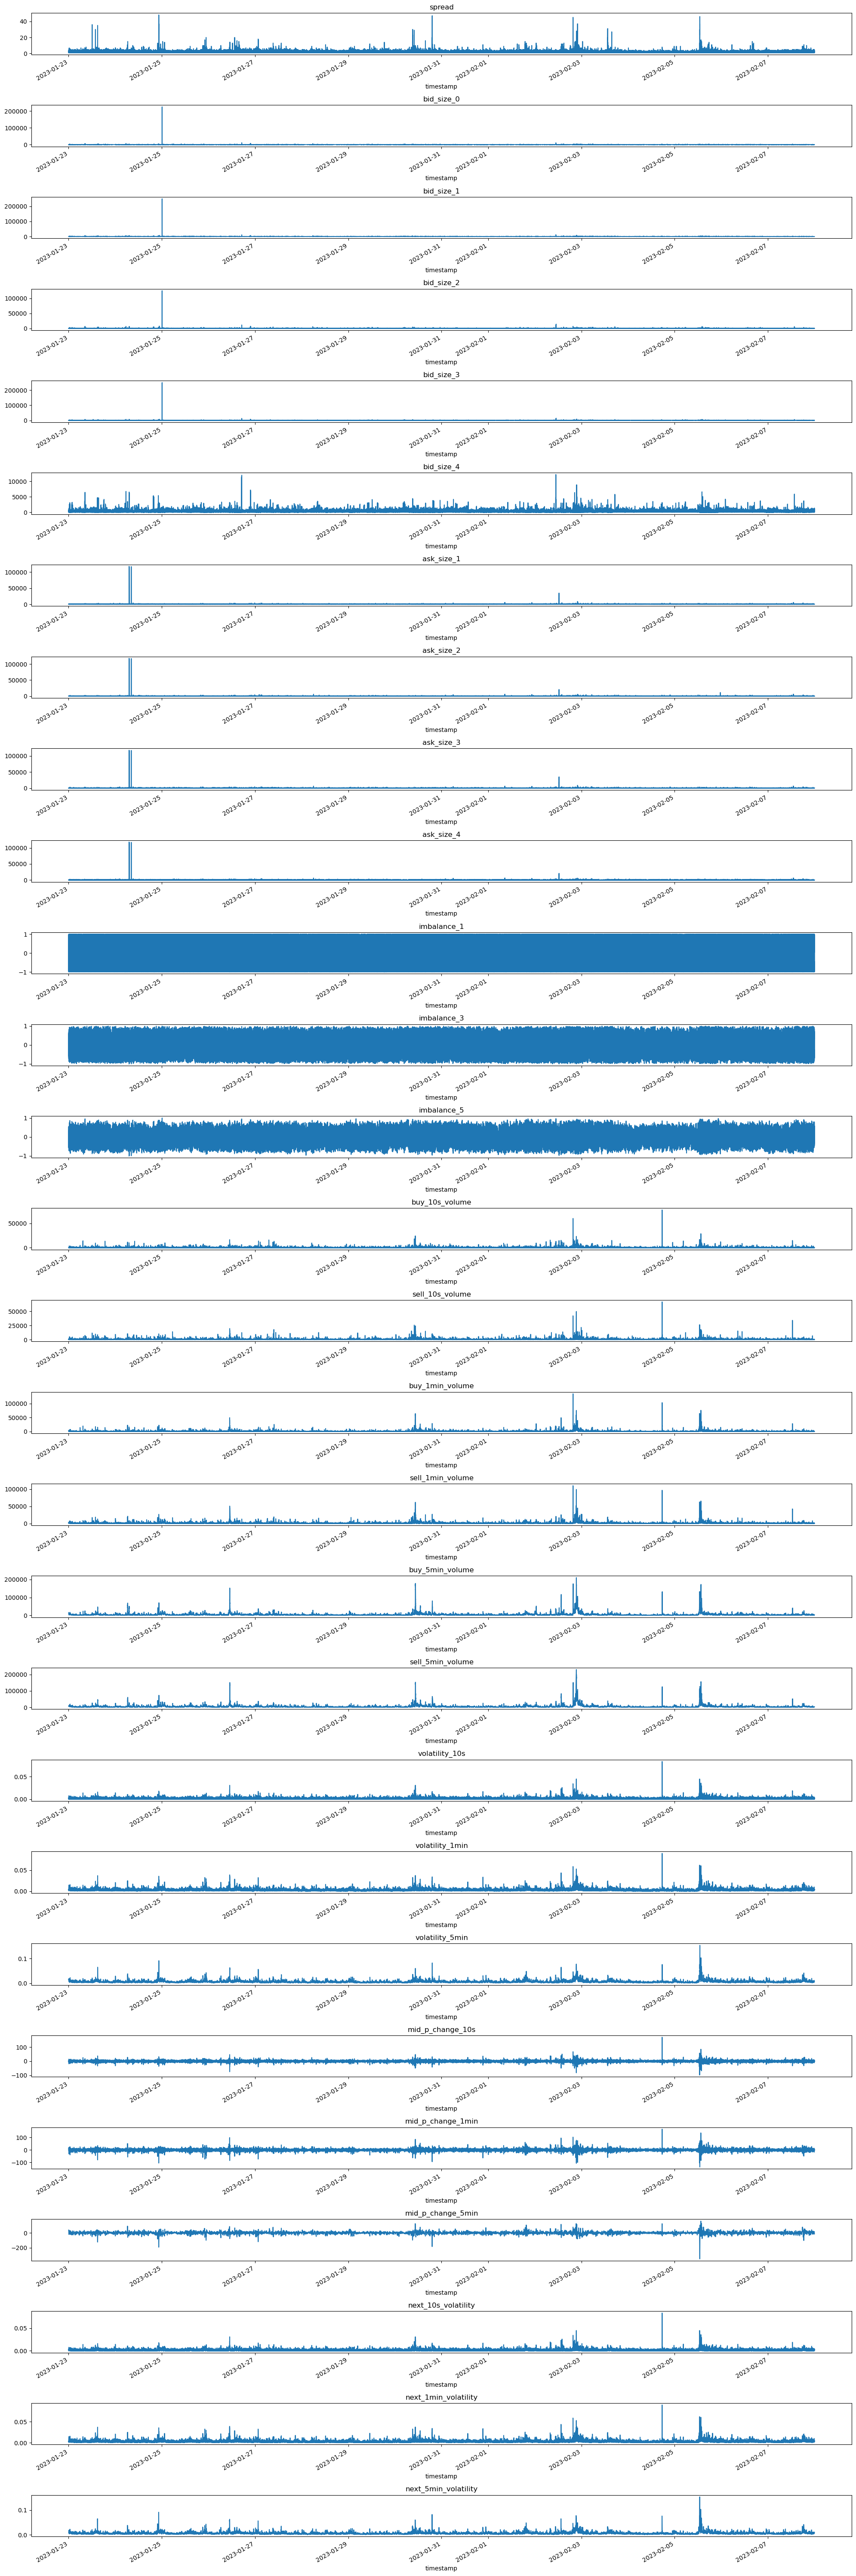

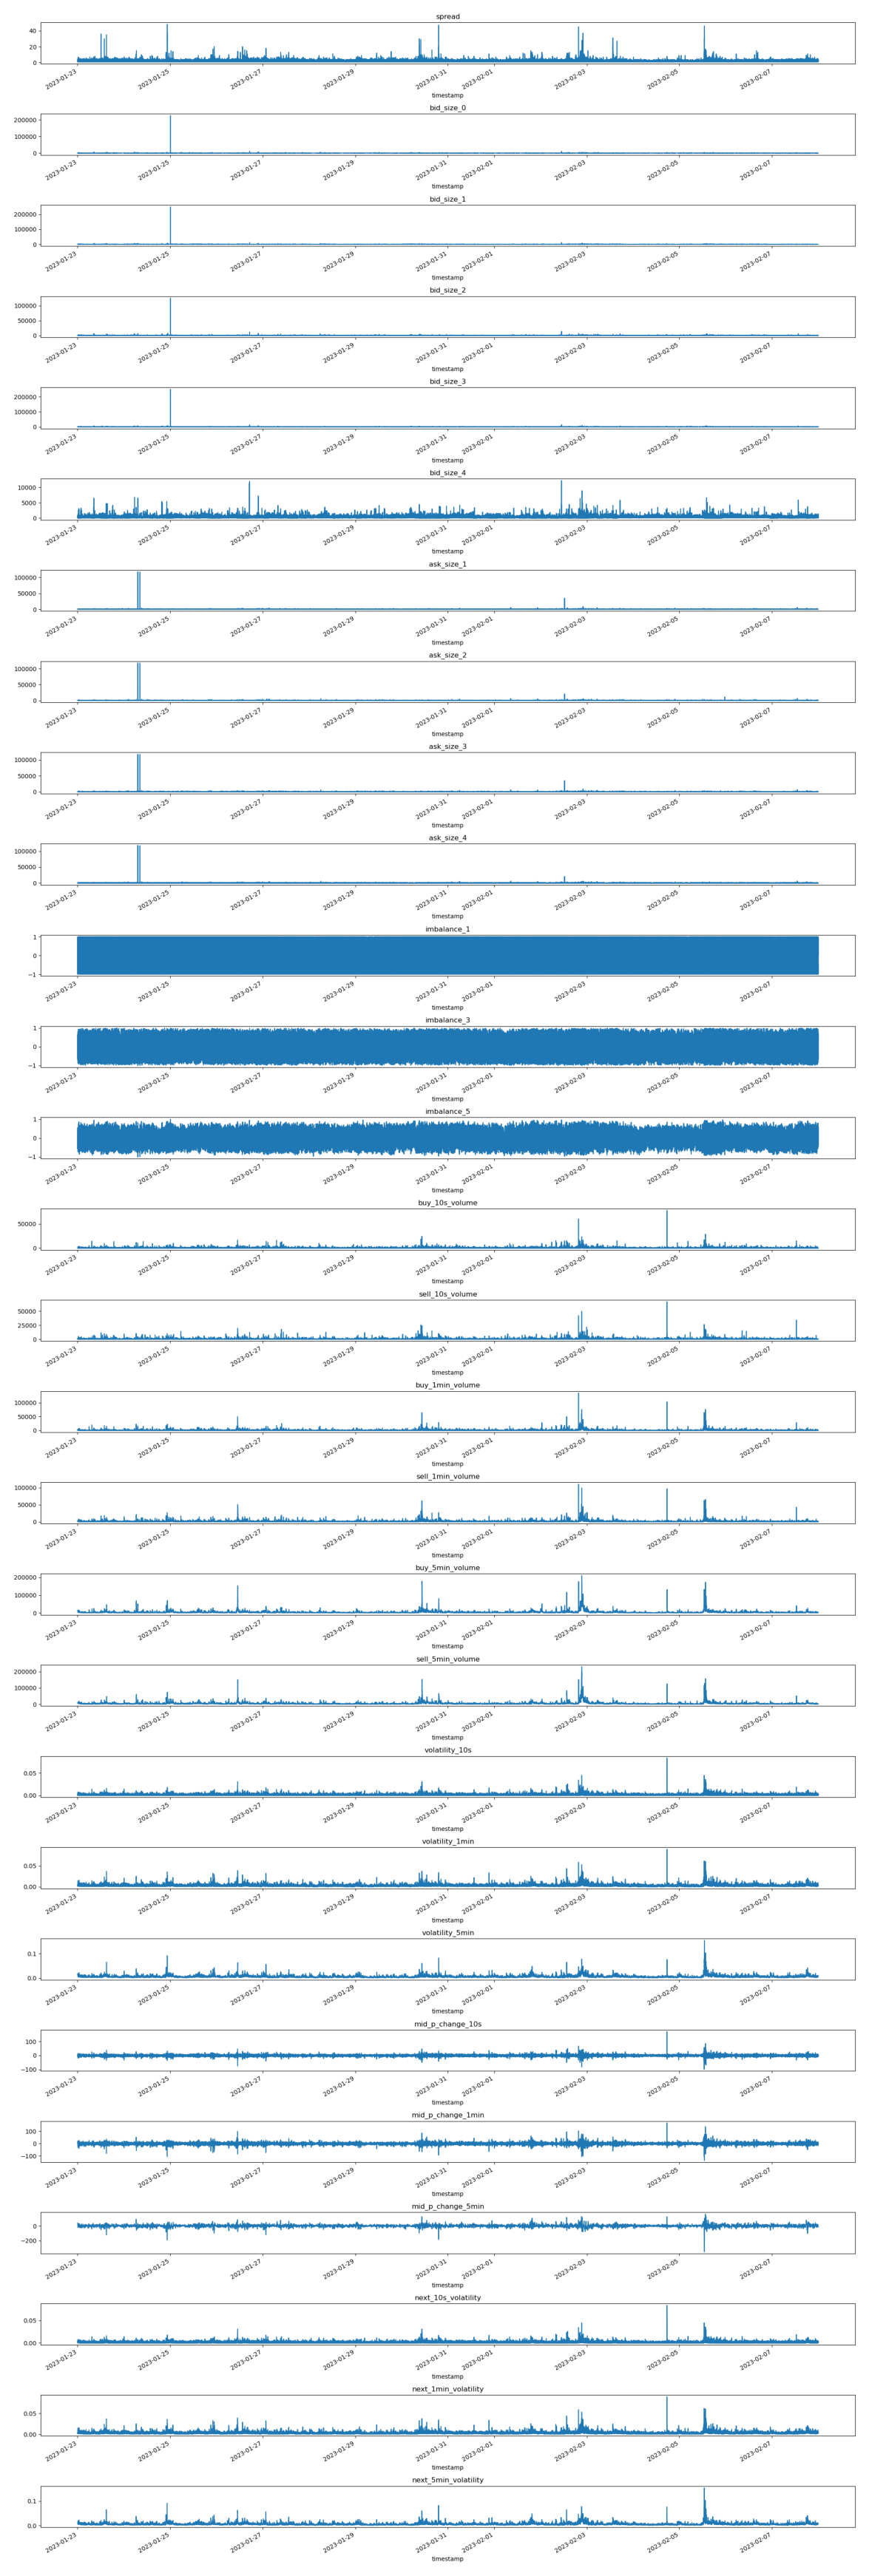

In [47]:
# Plotear líneas de cada variable:
fig, axs = plt.subplots(len(df.columns), 1, figsize=(20, 60))
for i, col in enumerate(df.columns):
    df[col].plot(ax=axs[i], title=col)
plt.tight_layout()
plt.savefig('images/lineplots_all_outs.png', dpi='figure')
plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/lineplots_all_outs.png')
plt.figure(figsize=(15,45))
plt.imshow(img)
plt.axis('off')
plt.show()

Tanto en el gráfico de boxplots como en el gráfico de líneas, notamos alta presencia de valores atípicos, en algunos casos, muy extremos. Fuentes teóricas del análisis de series de tiempo financiero y varias pruebas sobre los datos, sugieren fuertemente la no eliminación de estos. Si los outliers representan eventos reales, contienen información que puede resultar valiosa para el análisis. 

También, la presencia de valores extremos garantiza una granularidad media de 0.5 segundos en nuestros datos, lo cual es deseado para el entrenamiento de redes recurrentes como las LSTM, las cuales son sensibles a la secuencia y orden de los datos.

Sin embargo, al decidir mantener los outliers, es importante tener en cuenta cómo el modelo responde a ellos durante el entrenamiento y validación. Una estrategia intermedia es más bien suavizarlos o ajustarlos a un valor menos extremo, preservando así la granularidad mientras reducimos el impacto del ruido. Esta técnica se conoce como **capping**. Avanzaremos con esta técnica en la sección _Ingeniería de datos_.

## Estacionareidad

La estacionariedad es la propiedad de las series de tiempo en la cual las características estadísticas (como la media, la varianza y la estructura de autocorrelación) no cambian con el tiempo. En otras palabras, una serie estacionaria tiene propiedades que son consistentes a lo largo del tiempo.

La estacionariedad es importante en el análisis de series de tiempo porque muchos métodos y modelos estadísticos asumen esta propiedad. Si una serie no es estacionaria, puede llevar a predicciones poco fiables o engañosas. Hacer que una serie sea estacionaria a menudo es un paso esencial antes de modelarla, ya que mejora la precisión y la interpretabilidad de los modelos.

Para evaluar la estacionariedad de una serie de tiempo, utilizamos la **prueba de Dickey-Fuller aumentada (ADF)**. Esta prueba verifica la hipótesis nula (H0) de que una unidad de raíz está presente en una muestra de una serie de tiempo. Si la hipótesis nula se rechaza, se puede inferir que la serie de tiempo es estacionaria.

Dada la gran cantidad de observaciones en el conjunto de datos y el enorme costo computacional de la prueba, ejecutaremos `statsmodels.tsa.stattools.adfuller()` en una muestra del 10%.

In [48]:
# from statsmodels.tsa.stattools import adfuller

# Obtenemos la muestra del conjunto de datos:
row_sample = int(df.shape[0] / 10)
df_sample = df.iloc[:row_sample]

# # Ejecutamos adfuller() en cada columna del conjunto de datos y guardamos los valores-p:
# adfuller_p_values = []

# for col in df.columns:
#     p_value = adfuller(df_sample[col])[1]
#     adfuller_p_values.append(p_value)

# # Creamos un DataFrame que albergue loos valores-p de la prueba:
# adfuller_p_values_df = pd.DataFrame(
#     {'Series': df.columns,
#     'adfuller_p_values': adfuller_p_values}
# )
# # Verificamos si los valores-p son inferiores al umbral de significancia:
# adfuller_p_values_df['H0_rejected'] = adfuller_p_values_df['adfuller_p_values'] < 0.05

# # Guardamos los valores-p obtenidos en un archivo csv:
# adfuller_data = adfuller_p_values_df.to_csv('eda/adfuller_all_outs.csv')

# Imprimimos:
adfuller_data = pd.read_csv('eda/adfuller_test.csv', index_col=0)
adfuller_data

Series  adfuller_p_values  H0_rejected
0                 spread       0.000000e+00         True
1             bid_size_0       0.000000e+00         True
2             bid_size_1       0.000000e+00         True
3             bid_size_2       0.000000e+00         True
4             bid_size_3       0.000000e+00         True
5             bid_size_4       0.000000e+00         True
6             ask_size_1       0.000000e+00         True
7             ask_size_2       0.000000e+00         True
8             ask_size_3       0.000000e+00         True
9             ask_size_4       0.000000e+00         True
10           imbalance_1       0.000000e+00         True
11           imbalance_3       0.000000e+00         True
12           imbalance_5       0.000000e+00         True
13        buy_10s_volume       0.000000e+00         True
14       sell_10s_volume       0.000000e+00         True
15       buy_1min_volume       0.000000e+00         True
16      sell_1min_volume       0.000000e+00         True
17       buy_5min_volume       9.930799e-18         True
18      sell_5min_volume       1.690505e-16         True
19        volatility_10s       0.000000e+00         True
20       volatility_1min       0.000000e+00         True
21       volatility_5min       0.000000e+00         True
22      mid_p_change_10s       0.000000e+00         True
23     mid_p_change_1min       0.000000e+00         True
24     mid_p_change_5min       0.000000e+00         True
25   next_10s_volatility       0.000000e+00         True
26  next_1min_volatility       0.000000e+00         True
27  next_5min_volatility       0.000000e+00         True

En la muestra tomada, la prueba de Dickey-Fuller aumentada fuertemente sugiere que las todas series son estacionarias. Este es un dato importante previo al modelado y predicción de los datos. Esto implica que ninguna requerirá diferenciación previo al modelado. Sin embargo, es necesario actuar con cautela, puesto que estamos asumiendo que los datos se mantienen estacionarios en todo su espacio temporal.

## Autocorrelación

La **autocorrelación** (ACF) se refiere a la correlación de una serie temporal con una versión retrasada de sí misma. Esencialmente, mide la relación lineal entre un valor de la serie temporal y los valores de los periodos de tiempo anteriores. La autocorrelación puede ayudarnos a identificar patrones repetitivos o ciclos periódicos en una serie de tiempo, que no se pueden identificar con una inspección visual de los datos.

La **autocorrelación parcial** (PACF), por otro lado, es la correlación entre un valor y sus retrasos que no se explica por las correlaciones a todos los retrasos más bajos. Es decir, la autocorrelación parcial en el retraso kk es la correlación que resulta después de eliminar el efecto de cualquier correlaciones debido a los términos en retrasos más cortos.

A continuación, observamos los gráficos de ACF y PACF de todas las variables del conjunto de datos. Esto nos permitirá identificar qué tipos de a qué tipo de proceso corresponde cada una (autorregresivos o de media móvil). La información proporcionada por las gráficas de ACF y PACF puede ser útil en el proceso de ingeniería de características.

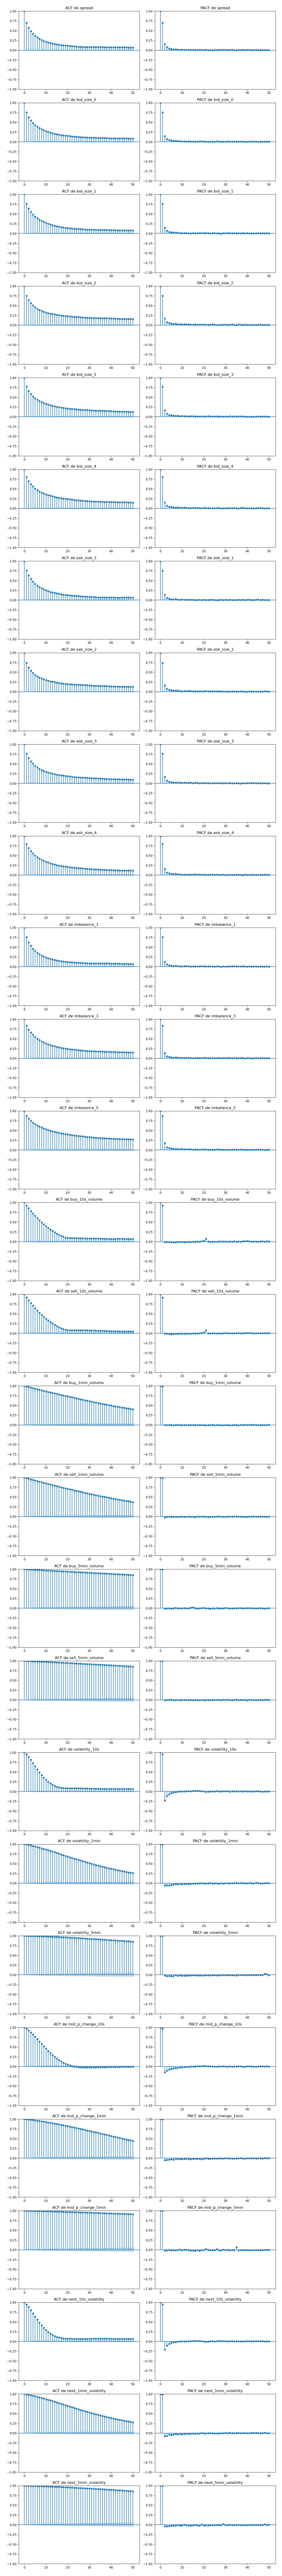

In [49]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Número de variables
# n_vars = df_sample.shape[1]

# # Creamos una cuadrícula de subgráficos:
# fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(12, 4 * n_vars))

# for i, column in enumerate(df_sample.columns):
#     plot_acf(df_sample[column], lags=50, alpha=0.05, ax=axes[i, 0], title=f"ACF de '{column}'")
#     plot_pacf(df_sample[column], lags=50, alpha=0.05, ax=axes[i, 1], title=f"PACF de '{column}'")

# plt.tight_layout()
# plt.savefig('images/var-acf-pacf.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/var-acf-pacf.png')
plt.figure(figsize=(20,100))
plt.imshow(img)
plt.axis('off')
plt.show()

Observamos que todas las variables son procesos autorregresivos (AR). Una serie temporal *AR(p)* es aquella influenciada por sus propios *p* valores pasados. Es decir, el valor de la serie en un punto de tiempo dado se considera una combinación lineal de los valores pasados. Esto tiene varias implicaciones en el análisis de datos y en el modelado LSTM para la predicción de precios o volatilidad. 

A continuación, se detallan algunas consideraciones y estrategias a tener en cuenta:

1. Dependencia Temporal:

- *Implicancia*: Los procesos AR tienen dependencias temporales, lo que significa que los valores actuales dependen de los valores pasados.
- *Estrategia*: Asegurarse de que el modelo LSTM esté configurado para manejar estas dependencias, eligiendo una longitud de secuencia (número de pasos de tiempo) que capture adecuadamente las dependencias temporales.

2. Estacionariedad:

- *Implicancia*: Los procesos AR pueden o no ser estacionarios, lo que puede afectar la eficacia del modelo.
- *Estrategia*: Verificar la estacionariedad de las series temporales y diferenciarlas si es necesario, para hacerlas estacionarias antes de alimentarlas al LSTM. En el punto previo, verificamos que todas las variables son estacionarias.

3. Complejidad del Modelo:

- *Implicancia*: Los procesos AR pueden requerir que el modelo aprenda patrones complejos debido a las dependencias temporales.
- *Estrategia*: Experimentar con la arquitectura del modelo LSTM (número de capas, número de unidades, etc.) para asegurarnos de que tiene la capacidad de aprender estos patrones.

4. Ingeniería de características:

- *Implicancia*: La naturaleza AR de las variables puede requerir la creación de características adicionales para mejorar el modelo.
- *Estrategia*: Considerar la creación de características adicionales, como _lags_, para ayudar al modelo a capturar las dependencias temporales.

5. Sobreajuste:

- *Implicancia*: Si las series temporales tienen muchas fluctuaciones y patrones complejos, el modelo puede sobreajustarse.
- *Estrategia*: Utiliza técnicas como la regularización y el dropout en el modelo LSTM para mitigar el sobreajuste.

6. Multicolinealidad:

- *Implicancia*: Utilizar lags de variables como características puede introducir multicolinealidad.
- *Estrategia*: Aplicar técnicas para manejar la multicolinealidad, como la regularización, o métodos avanzados de selección de características.

7. Desempeño del Modelo:

- *Implicancia*: La capacidad del LSTM para modelar dependencias temporales largas será importante para predecir procesos AR.
- *Estrategia*: Monitorear métricas de desempeño relevantes y ajustar el modelo según sea necesario.

## Multicolinealidad

La multicolinealidad es la correlación alta entre dos o más variables predictoras independientes en un modelo de regresión. En otras palabras, una variable predictora puede ser predicha a partir de otras variables predictoras en el modelo con un grado significativo de precisión.

En el contexto de las redes neuronales y LSTM, la multicolinealidad podría no ser tan crítica como en la regresión lineal clásica, ya que las redes neuronales pueden manejar cierto grado de correlación entre las variables. Sin embargo, la multicolinealidad puede seguir afectando la interpretación del modelo y la importancia de las variables, y también puede influir en la convergencia del modelo durante el entrenamiento.

Es prudente explorar y entender las correlaciones entre las variables para construir modelos más robustos y fáciles de interpretar, incluso cuando se utilizan técnicas de modelado más avanzadas como LSTM. Para detectar posible multicolinealidad entre las variables características, utilizamos el **factor de inflación de la varianza (VIF)**. 

In [50]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# Y_list = ["mid_p_change_10s", "mid_p_change_1min", "mid_p_change_5min", "next_10s_volatility", "next_1min_volatility", "next_5min_volatility"]

# # Separar la variable objetivo de las variables características: 
# X = df.drop(columns=Y_list)

# # VIF dataframe
# vif_data_all_outs = pd.DataFrame()
# vif_data_all_outs["feature"] = X.columns

# # Calculamos VIF para cada variable característica:
# vif_data_all_outs["VIF"] = [variance_inflation_factor(X.values, i)
#                    for i
#                    in range(len(X.columns))]

# # Almacenar el DataFrame como csv: 
# vif_data_all_outs.to_csv('eda/vif_test_data.csv')

# # Importar datos de VIF:
vif_data_all_outs = pd.read_csv('eda/vif_test_data.csv', index_col=0)
vif_data_all_outs = vif_data_all_outs.sort_values(by="VIF")

# Imprimir VIF:
vif_data_all_outs

feature        VIF
6         ask_size_1   1.163914
7         ask_size_2   1.233426
1         bid_size_0   1.236357
9         ask_size_4   1.296454
8         ask_size_3   1.308001
2         bid_size_1   1.403634
10       imbalance_1   1.492434
4         bid_size_3   1.765008
3         bid_size_2   1.904443
14   sell_10s_volume   2.358865
13    buy_10s_volume   2.433858
5         bid_size_4   2.513378
12       imbalance_5   2.955344
11       imbalance_3   3.331904
19    volatility_10s   3.590526
0             spread   4.390328
20   volatility_1min   5.596584
16  sell_1min_volume   6.023832
15   buy_1min_volume   6.212723
21   volatility_5min   6.326609
17   buy_5min_volume  13.615929
18  sell_5min_volume  14.077995

En el conjunto de datos hay varias características con multicolinealidad elevada (mayores a 5). Las variables `ask_size_0` y `bid_size_4` presentaban multicolinealidad perfecta, lo que significa que una podía ser representada como una combinación lineal de la otra. Por esta razón, se eliminó la primera con antelación. También, al crear nuevas variables, aparecerán varias con multicolinalidad perfecta.

Podemos abordar el problema de multicolinealidad con tres enfoques diferentes:

1. Utilizar los modelos de regularización y selección de variables **Lasso** y **Ridge**. Ambos métodos buscan evitar el sobreajuste, proporcionando soluciones más estables y robustas para penalizar los coeficientes de variables con alta multicolinealidad. Sin embargo, un desafío al usar Lasso y Ridge es que, al trar

2. Realizar **Análisis de Componentes Principales (PCA)**, cuyo objetivo principal es transformar un conjunto de variables, posiblemente correlacionadas, en un nuevo conjunto de variables no correlacionadas llamadas componentes principales. EL mayor desafío al usar PCA es que la interpretación de las componentes principales puede ser menos intuitiva en comparación con el uso de las variables originales.

3. La selección de variables con **regresión Random Forest** es bastante robusta a la multicolinealidad. No asume una forma funcional específica entre las variables explicativas y la variable objetivo, lo que lo hace menos susceptible a los problemas asociados con la multicolinealidad.

# **Variable objetivo**



### Selección de la variable objetivo

Contamos con un conjunto de variables objetivo candidatas. Estas variables miden las fluctuaciones de precio y de volatilidad en tres franjas de tiempo: `mid_p_change_10s, mid_p_change_1min, mid_p_change_5min, next_10s_volatility, next_1min_volatility, next_5min_volatility`. Para determinar las de mayor potencial predictivo, seguiremos dos criterios:el Mayor Exponente de Lyapunov (LLE) y el Análisis de Fluctuación sin Tendencia (DFA):

El **Mayor Exponente de Lyapunov** (LLE) es una métrica que mide la tasa de separación de trayectorias infinitesimalmente cercanas en un sistema a lo largo del tiempo, proporcionando así una cuantificación de la estabilidad o inestabilidad del sistema. **Un LLE positivo indica comportamiento caótico, mostrando que las trayectorias cercanas se separan exponencialmente con el tiempo**. Este exponente es permite entender la predictibilidad de un sistema dinámico, y es comúnmente utilizado para identificar la presencia de caos en el sistema, además de estimar el radio de producción de entropía del mismo, ofreciendo una comprensión más profunda de la naturaleza del sistema en estudio.

Para evaluar el LLE de las variables objetivo candidatas, utilizaremos la función personalizada `binance_utils.cross_validated_lle()` la cual ejecuta la función `nolds.lyap_r()` sobre segmentos consecutivos, escogidos aleatoriamente, de cada variable y con validación cruzada.

In [51]:
import nolds

# Definir lista de variables objetivo candidatas:
Y_list = ["mid_p_change_10s", "mid_p_change_1min", "mid_p_change_5min", "next_10s_volatility", "next_1min_volatility", "next_5min_volatility"]

# Analizamos el grado de caos de las variables objetivo, utilizando el Mayor Exponente de Lyapunov (LLE):
for col in Y_list:
    cv_lle = binance_utils.cross_validated_lle(df[col], cv=10, seed=123)
    print(f"Media CV LLE de '{col}': ", np.mean(cv_lle))

Media CV LLE de 'mid_p_change_10s':  0.027208402756026307
Media CV LLE de 'mid_p_change_1min':  0.0015187625299045398
Media CV LLE de 'mid_p_change_5min':  -0.00022441014908901989
Media CV LLE de 'next_10s_volatility':  0.005632905094787753
Media CV LLE de 'next_1min_volatility':  0.006240792930850054
Media CV LLE de 'next_5min_volatility':  -7.246757256916283e-05


El **Análisis de Fluctuación sin Tendencia** (DFA, por sus siglas en inglés Detrended Fluctuation Analysis) es una técnica utilizada para analizar series temporales, especialmente en contextos de procesos estocásticos, teoría del caos y análisis de señales. El DFA es útil para identificar correlaciones en series temporales, especialmente en series cortas donde las fluctuaciones no siempre pueden ser representadas adecuadamente​​. Se aplica para determinar la autoafinidad estadística de una señal, siendo especialmente útil para analizar series temporales que parecen ser procesos de memoria larga (por ejemplo, con función de autocorrelación que decae según una ley de potencias) o ruido 1/f​2​. 

Una de las ventajas del DFA sobre otros métodos convencionales es que permite el análisis de datos de una manera que supera ciertas complicaciones asociadas con otros tipos de análisis, como se menciona en el contexto del análisis de datos biológicos​​. También ha demostrado ser útil para revelar el alcance de las correlaciones de largo alcance en series de tiempo, y se ha utilizado en el análisis del comportamiento de series de tiempo financieras, empleando elementos de la geometría fractal​​.

Siguiendo la metodología robusta utilizada con LLE, la función personalizada `binance_utils.cross_validated_dfa()` ejecuta la función `nolds.dfa()` sobre segmentos consecutivos pero aleatorios, de cada variable, con validación cruzada.

In [52]:
# Analizamos el grado de autoafinidad estadística de las variables objetivo, utilizando el Análisis de Fluctuación sin Tendencia (DFA):
for col in Y_list:
    cv_lle = binance_utils.cross_validated_dfa(df[col], cv=10, seed=123)
    print(f"DFA alfa medio CV de '{col}': ", np.mean(cv_lle))

DFA alfa medio CV de 'mid_p_change_10s':  1.2712388050472352
DFA alfa medio CV de 'mid_p_change_1min':  1.796025988102502
DFA alfa medio CV de 'mid_p_change_5min':  1.9873158496913768
DFA alfa medio CV de 'next_10s_volatility':  1.1431490158268605
DFA alfa medio CV de 'next_1min_volatility':  1.6523121870557727
DFA alfa medio CV de 'next_5min_volatility':  1.9321061108254827


**Interpretación de los resultados de LLE y DFA cros-validados**:

- `mid_p_change_10s`: Tiene correlaciones a largo plazo y cierta sensibilidad a las condiciones iniciales, lo que sugiere que puede haber alguna predictibilidad pero con un grado de incertidumbre.

- `mid_p_change_1min` y `mid_p_change_5min`: Ambas variables muestran fuertes correlaciones a largo plazo (especialmente `mid_p_change_5min`), pero la sensibilidad a las condiciones iniciales es baja o estable, lo que sugiere que pueden ser más predecibles que `mid_p_change_10s`.

- `next_10s_volatility`: Presenta correlaciones a largo plazo y baja sensibilidad a las condiciones iniciales, lo que sugiere que puede haber alguna predictibilidad.

- `next_1min_volatility`: Aunque tiene fuertes correlaciones a largo plazo, la baja sensibilidad a las condiciones iniciales sugiere que puede ser relativamente predecible.

- `next_5min_volatility`: A pesar de las fuertes correlaciones a largo plazo, la estabilidad en términos de condiciones iniciales sugiere que esta variable podría ser la más predecible de las tres relacionadas con la volatilidad.

**Conclusión**:

- Las variables relacionadas con los cambios en el precio medio parecen tener fuertes correlaciones a largo plazo, especialmente cuando se observan en ventanas de tiempo más largas. El mejor caso es el de la variable `mid_p_change_5min`.

- Las variables relacionadas con la volatilidad futura también muestran correlaciones a largo plazo, pero la variable `next_5min_volatility` parece ser la más estable y, por lo tanto, potencialmente la más predecible.

- Por tanto, determinamos que las variables con mayor potencial para ser predichas son las de lazos temporales de 5 minutos.

### Distribución de la variable objetivo

In [53]:
import scipy.stats as stats

target_var = 'mid_p_change_5min'

Y = df[target_var]

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(Y)
print(f"Shapiro-Wilk Statistic: {shapiro_stat}, p-value: {shapiro_p}")

# Kurtosis y Asimetría
kurtosis_val = stats.kurtosis(Y)
skewness_val = stats.skew(Y)
print(f"Curtosis: {kurtosis_val}")
print(f"Asimetría: {skewness_val}")

# Test de Anderson-Darling
anderson_result = stats.anderson(Y)
print(f"Anderson-Darling Statistic: {anderson_result.statistic}")
for i in range(len(anderson_result.critical_values)):
    sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
    if anderson_result.statistic < cv:
        print(f"Nivel de significancia: {sl}, valor crítico: {cv} - Se observa una distribución normal")
    else:
        print(f"Nivel de significancia: {sl}, valor crítico: {cv} - No se observa una distribución normal")

c:\Users\ivan_\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Statistic: 0.8786693811416626, p-value: 0.0
Curtosis: 32.863421646606575
Asimetría: -1.5697529958642047
Anderson-Darling Statistic: 37456.7837231406
Nivel de significancia: 15.0, valor crítico: 0.576 - No se observa una distribución normal
Nivel de significancia: 10.0, valor crítico: 0.656 - No se observa una distribución normal
Nivel de significancia: 5.0, valor crítico: 0.787 - No se observa una distribución normal
Nivel de significancia: 2.5, valor crítico: 0.918 - No se observa una distribución normal
Nivel de significancia: 1.0, valor crítico: 1.092 - No se observa una distribución normal


La prueba de Shapiro-Wilk arrojó un estadístico de 0.879 y un valor p de 0.0, lo que indica que la distribución no es normal. Además, la kurtosis de la distribución es de 32.9, lo que sugiere una alta concentración de los datos alrededor de la media, y una asimetría (skewness) de -1.57, lo que indica una ligera inclinación hacia la izquierda. La prueba de Anderson-Darling, que es otra prueba de normalidad, dio un estadístico de 37456. Al evaluar diferentes niveles de significancia, desde el 15% hasta el 1%, en todos los casos los valores críticos (desde 0.576 hasta 1.092) sugieren que no se observa una distribución normal.

Sin embargo, la falta de normalidad de la variable objetivo `mid_p_change_5min` no necesariamente supone un problema para un modelo LSTM. Al igual que otras redes neuronales, las LSTM son modelos no paramétricos que no hacen suposiciones fuertes sobre la distribución de los datos. Pueden aprender patrones complejos y relaciones no lineales en los datos sin la necesidad de que la variable objetivo siga una distribución específica.

Finalmente, aunque no es necesario que la variable a predecir tenga una distribución normal, a veces puede ser útil transformar la variable para estabilizar la varianza o hacer que la distribución sea más simétrica. Esto puede ayudar a mejorar el desempeño del modelo en algunos casos.

# **Ingeniería de características**

### Tratamiento de valores atípicos

Previo a la creación de nuevas variables características, es necesario abordar el problema de outliers. Como habíamos observado anteriormente, existe presencia de outliers en los datos que, en algunos casos, representan valores muy extremos. El recorte o **capping** de outliers es una técnica utilizada para limitar o restringir los valores extremos en un conjunto de datos a un rango específico sin necesidad de eliminarlos. Este proceso ayuda a mitigar el efecto de los valores atípicos que pueden sesgar o influir indebidamente en el modelado de datos.

Las redes recurrentes también pueden ser afectadas por outliers, especialmente en series temporales donde un valor atípico puede tener un efecto en cascada a lo largo del tiempo. Aunque las arquitecturas LSTM pueden ser un poco más robustas a outliers, gracias a su capacidad para mantener u "olvidar" información a lo largo del tiempo, durante los experimentos realizados se observó que aplicar un *capping* conservador (valores posicionados sobre los 3 rangos intercuartiles en cada cola) mejoró la convergencia del modelo y su capacidad predictiva.

In [54]:
# Cargar datos:
df = pd.read_parquet('datasets/binance.parquet')

# Establecer 'timestamp' como índice:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Definir lista de variables objetivo candidatas:
Y_list = ["mid_p_change_10s", "mid_p_change_1min", "mid_p_change_5min", "next_10s_volatility", "next_1min_volatility", "next_5min_volatility"]

target_var = 'mid_p_change_5min'

In [55]:
df_capped = pd.DataFrame()

multiplier = 3 # multiplicador del IQR.

for col in df.columns:
    df_capped[col] = binance_utils.apply_outlier_capping(df[col], multiplier=multiplier)

df_capped.index = df.index

Tras aplicar la técnica de *capping* a los valores extremos por encima de 3 rangos intercuartiles, comparamos los resultados con los datos originales:

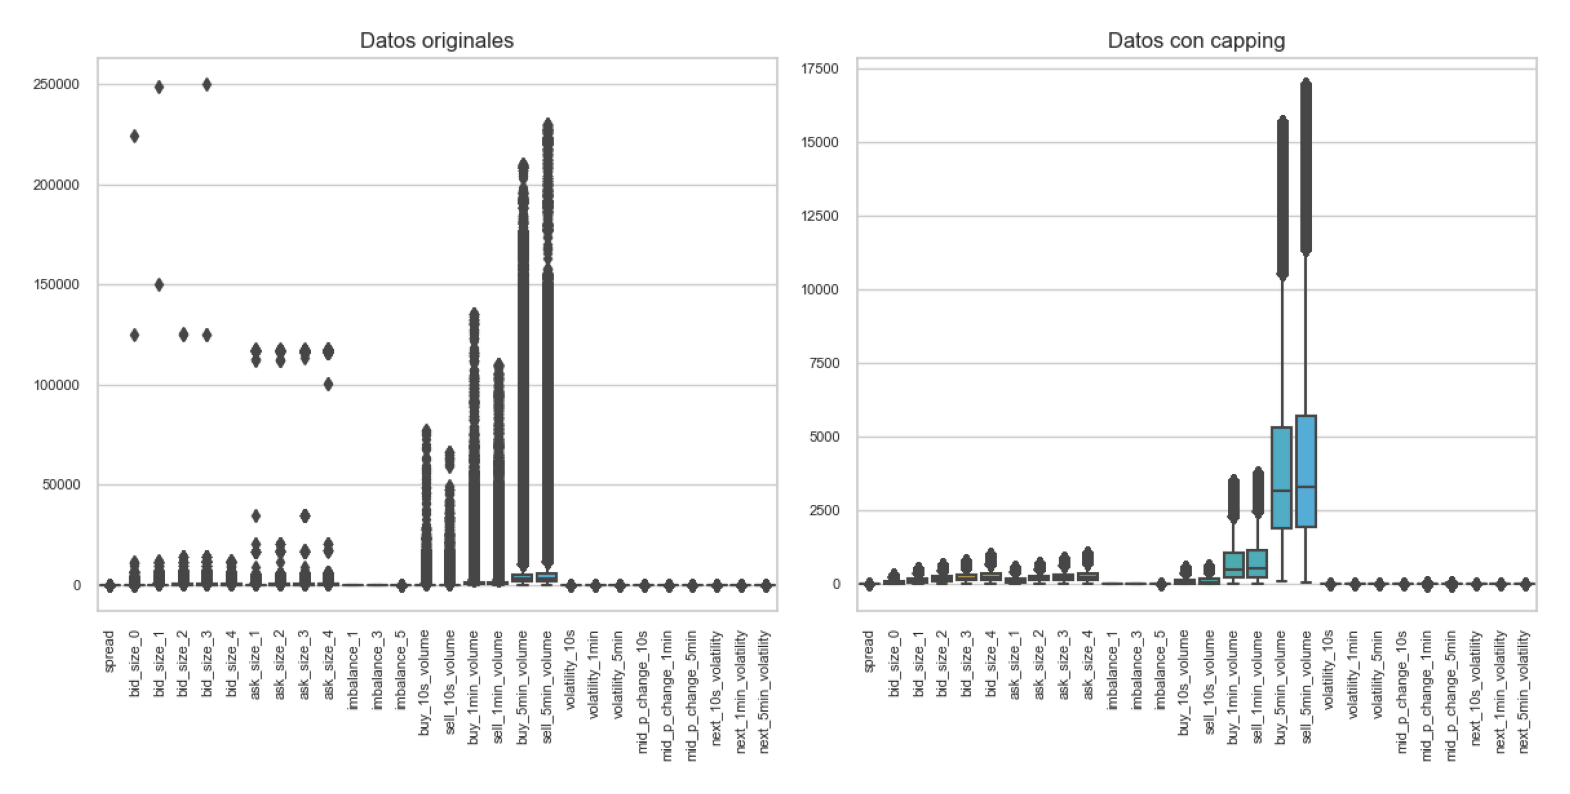

In [56]:
# # Configurar el estilo de Seaborn para una estética mejorada
# sns.set(style="whitegrid")

# # Crear una nueva figura
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Graficar boxplots
# sns.boxplot(data=df, ax=axs[0]).set(title='Datos originales')
# sns.boxplot(data=df_capped, ax=axs[1]).set(title='Datos con capping')

# # Modificar el tamaño y la rotación de los ticks del eje x
# for ax in axs:
#     ax.tick_params(axis='x', rotation=90, labelsize=8)
#     ax.tick_params(axis='y', rotation=0, labelsize=8)

# # Ajustar el espacio entre los plots
# plt.tight_layout()
# plt.savefig('images/capping-comparison-boxplots.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/capping-comparison-boxplots.png')
plt.figure(figsize=(20,100))
plt.imshow(img)
plt.axis('off')
plt.show()

In [57]:
# Por conveniencia futura, renombramos df_capped como df:
df = df_capped.copy()

### Creación de nuevas variables características

1. Las variables de media móvil ayudan a suavizar los datos y capturar tendencias a corto plazo. Creamos este tipo de variables de 10 segundos y 1 minutos, para sus lapsos de tiempo superiores: 1 minuto y 5 minutos para las variables de 10 segundos y 5 minutos para las de 1 minuto.

In [58]:
# Variables de 10 segundos
variables_10s = ['spread', 'imbalance_1','buy_10s_volume', 'sell_10s_volume', 'volatility_10s'] # 'bid_size_0'

# Variables de 1 minuto:
variables_1min = ['imbalance_3', 'buy_1min_volume', 'sell_1min_volume', 'volatility_1min']

# Medias móviles:
for var in variables_10s:
    df[f'{var}_ma_1min'] = df[var].rolling(window=120).mean()  # Media móvil de 1 minuto
    df[f'{var}_ma_5min'] = df[var].rolling(window=600).mean()  # Media móvil de 5 minutos

for var in variables_1min:
    df[f'{var}_ma_5min'] = df[var].rolling(window=600).mean()  # Media móvil de 5 minutos

2. Los retrasos de las variables de desbalance pueden ayudar a:

- Capturar Cambios: Estas variables capturan los cambios en el desequilibrio de órdenes de compra y venta a lo largo de un periodo de tiempo específico (5 minutos en este caso).

- Identificar Movimientos: Pueden ayudar a identificar movimientos significativos en el desequilibrio de órdenes, lo que podría estar asociado con movimientos de precios.

- Anticipar Presión de Compra/Venta: Cambios en el desequilibrio pueden indicar una presión de compra o venta en el mercado, lo que podría afectar los precios futuros.

In [59]:
# Establecer un retraso de 5 minutos:
lag_num = 2*60*5

# Cambio en el desbalance:
df['imbalance_1_change'] = df['imbalance_1'].diff(lag_num)
df['imbalance_3_change'] = df['imbalance_3'].diff(lag_num)
df['imbalance_5_change'] = df['imbalance_5'].diff(lag_num)

3. Las variables de relación compra/venta son útiles para identificar períodos de compra o venta intensa. El uso del logaritmo ayuda a suavizar valores extremos y sumar 1 en el denominador evita la generación de valores infinitos si existen observaciones con venta cero.

In [60]:
# Relación Volumen de Compra/Venta. Nota: El divisor suma 1 para evitar valores infinitos.
df['log_buy_sell_volume_ratio_10s'] = np.log(df['buy_10s_volume'] / (df['sell_10s_volume'] + 1) + 1)
df['log_buy_sell_volume_ratio_1min'] = np.log(df['buy_1min_volume'] / (df['sell_1min_volume'] + 1) + 1)
df['log_buy_sell_volume_ratio_5min'] = np.log(df['buy_5min_volume'] / (df['sell_5min_volume'] + 1) + 1)

4. Las características con retraso (lag) pueden capturar relaciones temporales en los datos. Especialmente útiles pueden resultar las variables retraso de la variable objetivo `mid_p_change_5min`, puesto que los valores pasados pueden influir en gran medida en los valores futuros. Sin embargo, es necesario recordar modelar esta variable de retraso con cautela, pues son propensas a introducir sobreajuste, multicolinealidad y a opacar otras variables características del modelo.

In [61]:
# Características lag, creadas según lo observado en los gráficos de ACF y PACF:
for col in ['spread', 'imbalance_1', 'imbalance_3', 'imbalance_5']:
        df[f'{col}_lag_1'] = df[col].shift(lag_num)

# Crear lag para variable objetivo:
df[f'{target_var}_lag_1'] = df[target_var].shift(300)

5. Las características de interacción pueden capturar relaciones no lineales entre las variables. En nuestro caso específico, la interacción entre `spread` e `imbalance_1` podría revelar cómo la combinación del `spread` (la diferencia entre los precios de compra y venta) `imbalance_1` (desequilibrio de orden 1) afecta el comportamiento del precio del activo.

In [62]:
# Interacción entre spread e imbalance_1:
df['spread_imbalance1'] = df['spread'] * df['imbalance_1']

6. La puntuación estándar es útil para identificar cuántas desviaciones estándar está un punto de datos del promedio móvil.

In [63]:
# # Puntuación estándar para ventanas de 10 segundos, 1 y 5 minutos. Nota: El divisor suma 1 para evitar valores infinitos.
for window in [20, 120, 600]: # ventanas de 10 segundos, 1 minuto, 5 minutos:
     df[f'z_score_spread_{window}'] = (df['spread'] - df['spread'].rolling(window=window).mean()) / \
         (df['spread'].rolling(window=window).std() + 1)

7. La creación de variables de oferta y demanda totales son útiles para capturar las tendencias generales y también para reducir la dimensionalidad. Por su parte, la Relación Bid/Ask totales es una característica importante que puede capturar la dinámica entre las ofertas y demandas en el mercado. Una relación alta podría indicar una mayor demanda, mientras que una relación baja podría indicar una mayor oferta.

In [64]:
# Variable "bid" acumulativa.
df['bid_total_size'] = df[['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4']].sum(axis=1)
df.drop(columns=['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4'], inplace=True)

# Variable "ask" acumulativa.
df['ask_total_size'] = df[['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4']].sum(axis=1)
df.drop(columns=['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4'], inplace=True)

# Relación Bid/Ask:
df['bid_ask_ratio'] = df['bid_total_size'] / df['ask_total_size']

8. El Rango Verdadero (TR) y el Rango Verdadero Medio (ATR) son indicadores técnicos utilizados para medir la volatilidad del mercado. El ATR, en particular, proporciona una medida promedio de la volatilidad durante un período de tiempo específico; en nuestro caso definido para 1 hora.

In [65]:
# Cálculo del Rango Verdadero (TR):
current_value = df['spread']
previous_value = df['spread'].shift(1)

# TR se calcula como el máximo entre: 
# (1) la diferencia entre el valor actual y el anterior, 
# (2) el valor absoluto entre el valor actual y el anterior, 
# (3) el valor absoluto entre el valor anterior y el actual.
df['tr'] = np.maximum(current_value - previous_value, 
                      np.maximum(np.abs(current_value - previous_value), 
                                 np.abs(previous_value - current_value)))

# Cálculo del Rango Verdadero Medio (ATR) usando un promedio móvil simple para un período de 1 hora:
window_size = 60 * 60 * 2  # 1 hora con granularidad de 0.5 segundos
df['atr'] = df['tr'].rolling(window=window_size).mean()

# Eliminar la columna 'tr' ya que es solo un cálculo intermedio:
df.drop(columns=['tr'], inplace=True)

In [66]:
# Eliminar las filas NaN generadas durante la creación de características:
df = df.dropna()

# Crear el conjunto de variables características:
X = df.drop(columns=Y_list)

# Extraer variable objetivo:
Y = df[target_var]

## Relaciones de las variables características con la variable objetivo

#### Correlación de Spearman

En esta ocasión, únicamente revisamos la correlación de Spearman de todas las variables características con la variable objetivo.

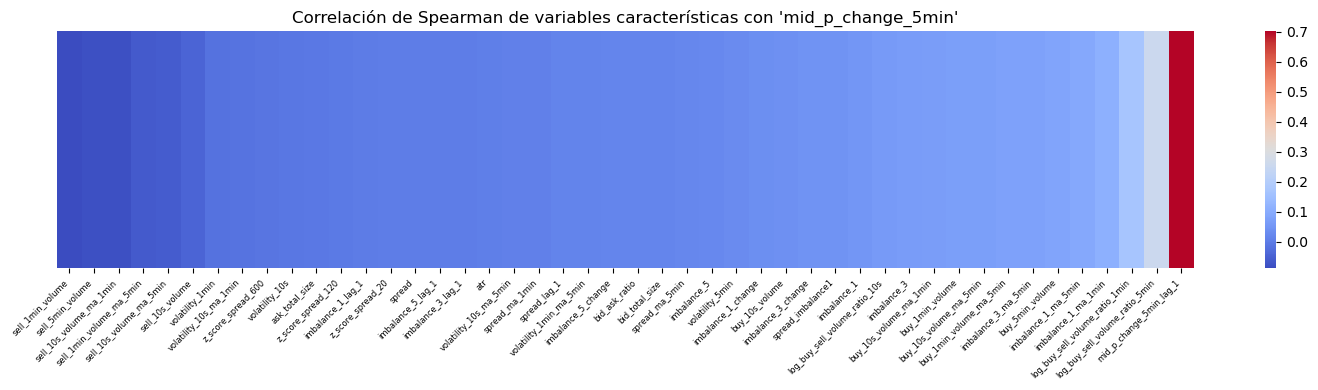

In [67]:
# Calcular la matriz de correlación
corr = pd.concat([X, Y], axis=1).corr(method='spearman')

# Extraer las correlaciones de 'y' con todas las otras variables
y_corr = corr.loc[:, target_var].sort_values()

# Crear un DataFrame con las correlaciones ordenadas de 'y'
sorted_corr = pd.DataFrame(y_corr).T.drop(columns=[target_var])

# Crear un mapa de colores que va desde azul (frío) a blanco (neutro) a rojo (caliente)
# cmap = sns.diverging_palette(250, 0, s=75, l=40, n=9, as_cmap=True)

# Ajustar el tamaño del gráfico para que sea más ancho
plt.figure(figsize=(15, 4))
sns.heatmap(sorted_corr, annot=False, cmap='coolwarm', cbar=True, linewidths=0, linecolor='none')

# Establecer el título y ajustar las etiquetas
plt.title(f"Correlación de Spearman de variables características con '{target_var}'")
plt.xticks(rotation=45, ha='right', fontsize=6)

 # Ocultar el nombre del índice en el eje y
plt.yticks([]) 

plt.tight_layout()
plt.show()


### Gráficos de dispersión y revisión de posibles relaciones lineales

Revisamos los gráficos de dispersión de cada variable característica en relación con la variable objetivo. También chequeamos posibles relaciones lineales. Debido a la gran cantidad de observaciones en el conjunto de datos, para las gráficas tomamos un muestra sistemática considerando su naturaleza temporal.

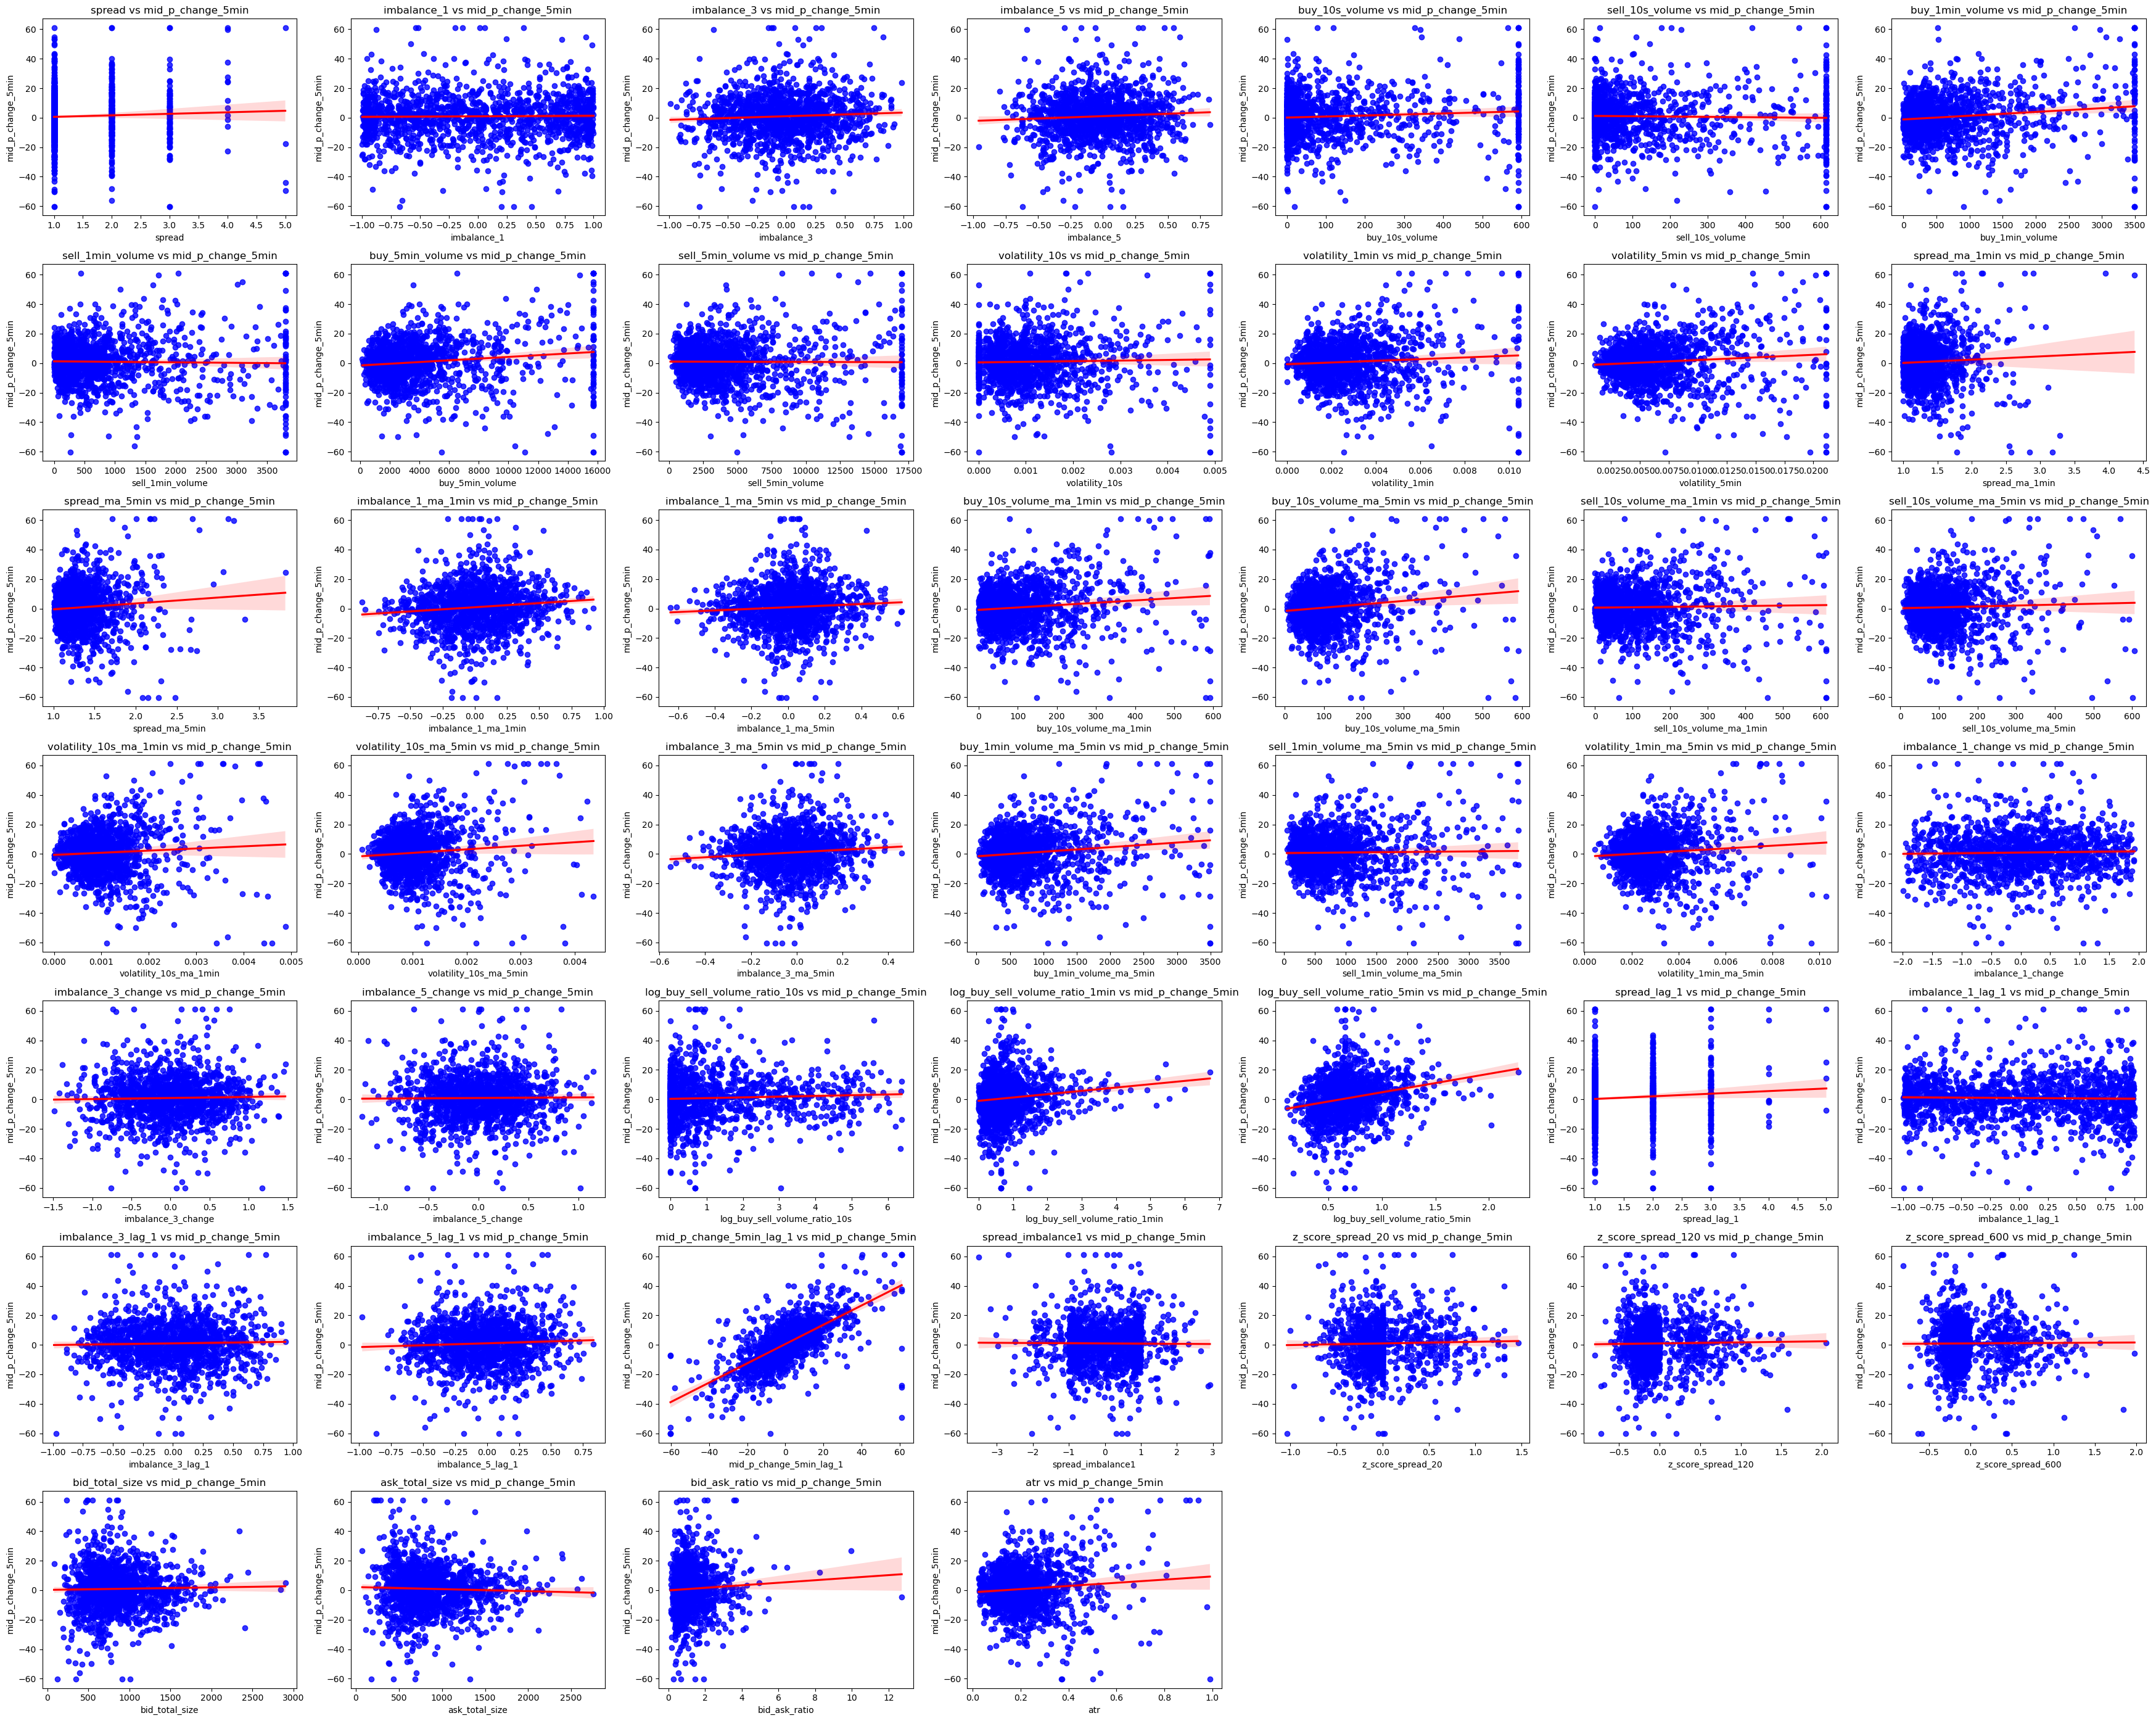

In [68]:
# Muestreo sistemático: selecciona cada 2000º elemento.
n = 2000
df_sample = df[::n]

X_sample = df_sample.drop(columns=Y_list)
y_sample = df_sample[target_var]

# Número de características en X
num_features = X_sample.shape[1]

# Determinar el número de filas y columnas para la cuadrícula
num_rows = int(np.ceil(np.sqrt(num_features)))
num_cols = int(np.ceil(num_features / num_rows))

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5*num_cols, 4*num_rows))

# Si solo hay una característica, axes no es una lista, así que lo convertimos en una lista para la iteración
if num_features == 1:
    axes = [axes]

# Aplanar la lista de ejes para facilitar la iteración
axes = np.array(axes).flatten()

# Iterar sobre cada característica y crear un diagrama de dispersión con línea de regresión
for i, col in enumerate(X_sample.columns):
    sns.regplot(x=X_sample[col], y=y_sample, ax=axes[i], color='blue', line_kws={"color": "red"})
    
    axes[i].set_title(f'{col} vs {target_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target_var)

# Eliminar cualquier eje adicional que no se use
for j in range(num_features, num_rows*num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Selección de características

La selección de variables correcta es un desafío fundamental dentro del diseño de nuestro modelo LSTM. Previamente, creamos una importante cantidad de variables a partir del conjunto original. En primera instancia, estas variables buscan capturar distintos patrones, fluctuaciones y tendencias con la finalidad de crear un modelo predictivo robusto. Sin embargo, no todas las variables tendrán una utilidad práctica para predecir nuestra variable objetivo. Por tanto, será necesario dejar de lado algunas variables sin capacidad predictiva sobre `mid_p_change_5min`, para diseñar un modelo con una cantidad de variables óptima.

Un desafío adicional es evitar potenciales problemas de multicolinealidad entre las variables objetivo seleccionadas. Aunque los modelos LSTM tienen un grado de robustez ante la multicolinealidad en comparación con modelos lineales tradicionales, la multicolinealidad puede afectar la interpretabilidad, estabilidad del modelo, eficiencia del aprendizaje, y sobreajuste. También puede aumentar la complejidad computacional y dificultar la selección de características. 

Para mitigar estos efectos, en este trabajo emplearemos dos enfoques por separado: 

1. Reducción de dimensionalidad mediante Análisis de Componentes Principales (PCA).
2. Selección no lineal de características mediante Random Forest.


# **1. Modelo LSTM con Análisis de Componentes Principales**

El **Análisis de Componentes Principales** (PCA) es una técnica de reducción de dimensionalidad que transforma un conjunto de variables posiblemente correlacionadas en un conjunto de variables no correlacionadas llamadas componentes principales. PCA puede ser útil para el modelado de series temporales con LSTM en varios aspectos:

a) *Reducción de dimensionalidad:* Al existir muchas variables, PCA reduce la dimensionalidad de los datos manteniendo la mayoría de varianza. Esto puede hacer que el entrenamiento del modelo LSTM sea más eficiente y maneje mejor la multicolinealidad.

b) *Desempeño del modelo:* Al eliminar la multicolinealidad y reducir el ruido en los datos, PCA podría ayudar a mejorar el desempeño del modelo.

c) *Prevención del sobreajuste:* Al reducir la cantidad de variables, el PCA puede prevenir el sobreajuste.

1. Escalar variables con `sklearn.preprocessing.RobustScaler`. Este escalador es robusto a valores atípicos. 

In [69]:
from sklearn.preprocessing import RobustScaler

# Escalar las características:
X_scaler = RobustScaler()
X_scaled = X_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

2. Efectuar Análisis de Componentes Principales con `sklearn.decomposition.PCA` y obtener el número de componentes principales que acumulan un nivel de varianza especificado.

Núm. de componentes principales que acumulan 90.0% de varianza:  17


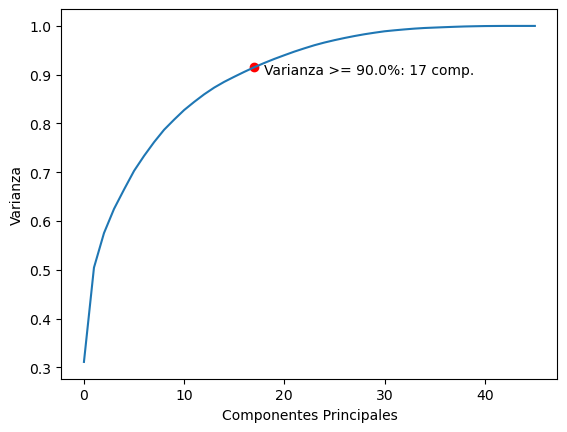

In [70]:
from sklearn.decomposition import PCA

# Instanciamos, ajustamos, transformamos y obtenemos el ratio de varianza explicada:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
exp_variance = pca.explained_variance_ratio_

# Número mínimo de componentes principales que acumulan al menos un valor requerido de varianza:

requested_variance = 0.90
exp_variance_cum_sum = np.cumsum(exp_variance)
n_components = min(np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1, len(exp_variance_cum_sum) - 1)
#n_components = np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1
print(f"Núm. de componentes principales que acumulan {requested_variance * 100}% de varianza: ", n_components)

# Graficamos:
plt.plot(exp_variance_cum_sum)
plt.scatter(n_components, exp_variance_cum_sum[n_components], color='red', marker='o')
plt.text(n_components+1, exp_variance_cum_sum[n_components]-.015, f"Varianza >= {requested_variance * 100}%: {n_components} comp.", fontsize=10)
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza')
plt.show()

In [71]:
# Crear un DataFrame con las componentes principales seleccionadas
X_pca_df = pd.DataFrame(data=X_pca[:, :n_components], columns=[f'PC{i}' for i in range(1, n_components + 1)], index=X.index)
X_pca_df.shape

(2738376, 17)

3. Aunque un subconjunto de 17 componentes principales captura al menos el 90% de varianza de las variables características, esto no necesariamente significa que todos estos componentes principales tienen capacidad predictiva sobre nuestra variable objetivo. Un método simple para determinar si existe una relación entre los componentes principales seleccionados es la regresión lineal. 

En el modelo de regresión lineal obtenido con `statsmodels.OLS`, notamos que todos los componentes principales tienen una relación lineal significativa (valor-p < 0.05) con `mid_p_change_5min`, aunque no todos tienen un valor de coeficiente elevado. También notamos que, gracias al PCA, no existen problemas de multicolinealidad.

In [72]:
# Obtener las variables características regularizadas con una constante:
const_pca_X = sm.add_constant(X_pca_df)

Y = df[target_var].to_frame()

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(Y, const_pca_X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      mid_p_change_5min   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 9.466e+04
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:22:14   Log-Likelihood:            -1.0462e+07
No. Observations:             2738376   AIC:                         2.092e+07
Df Residuals:                 2738358   BIC:                         2.092e+07
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2932      0.007     43.951      0.0

4. Como un filtro adicional, ajustaremos un modelo conjunto de selección de variables **Lasso** y **Ridge**. **Lasso** selecciona características al hacer que algunos coeficientes sean cero, simplificando el modelo, mientras que **Ridge** aborda la multicolinealidad al penalizar el tamaño de los coeficientes. Ambas técnicas permiten seleccionar variables (componentes principales) relevantes y así prevenir el sobreajuste y mejorar la robustez del modelo.

In [73]:
# from sklearn.preprocessing import RobustScaler

# # Escalamos las características con la clase StandardScaler()
# scaler = RobustScaler()
# df_scaled = scaler.fit_transform(df)
# df_scaled = pd.DataFrame(
#     df_scaled,
#     columns=scaler.get_feature_names_out(df.columns)
#     )

Y_scaler = RobustScaler()
Y_scaled = Y_scaler.fit_transform(Y)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns, index=Y.index)
X_scaled = X_pca_df

In [74]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Dividimos los datos en conjuntos de entrenamiento y prueba:

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X_scaled) * 0.8)

# Dividir los datos
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = Y_scaled[target_var][:train_size], Y_scaled[target_var][train_size:]

# Entrenamos el modelo Lasso
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Entrenamos el modelo Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

print("Modelo Lasso: ", lasso_mse)
print("Modelo Ridge: ", ridge_mse)

Modelo Lasso:  0.9731800595659955
Modelo Ridge:  0.4728021138100402


In [75]:
from sklearn.linear_model import LassoCV

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_scaled, Y_scaled)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso: ", lasso_mse)

Alpha óptimo para Lasso: 0.0001
MSE Lasso:  0.47125422181911625


In [76]:
from sklearn.linear_model import RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_scaled, Y_scaled)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge: ", ridge_mse)

Alpha óptimo para Ridge: 100.0
MSE Ridge:  0.4712665456291552


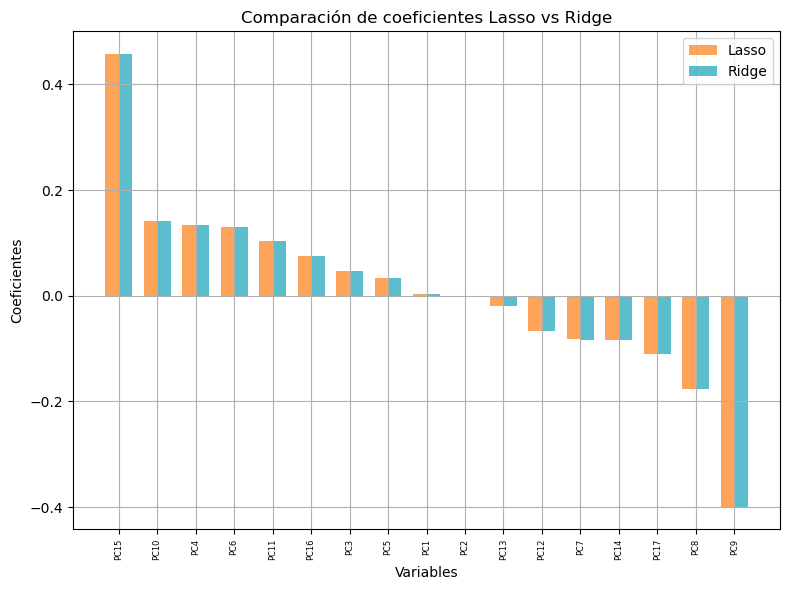

In [77]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_scaled.columns, 
    'lasso_coefs': lasso_opt.coef_.flatten(),
    'ridge_coefs': ridge_opt.coef_.flatten()}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by='ridge_coefs', ascending=False)

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

La función personalizada `binance_utils.select_features_from_regularization()` elimina características (en este caso, componentes principales) que no superen un umbral mínimo de los coeficientes Lasso y Ridge en relación con la variable objetivo.

In [78]:
# Utilizar la función filtro de variables con Lasso y Ridge: 
PCA_L1L2_X_list = binance_utils.select_features_from_regularization(
    regularization_coefs, # Matriz de coeficientes de regularización
    lasso_threshold=0.01, # 0.02
    ridge_threshold=0.01 # 0.02
    )

PCA_L1L2_X = X_pca_df[PCA_L1L2_X_list]

# Revisar las variables seleccionadas:
PCA_L1L2_X_list = sorted(PCA_L1L2_X_list)

# Creamos un dataframe con los componentes principales seleccionados: 
X_scaled = X_pca_df[PCA_L1L2_X_list]

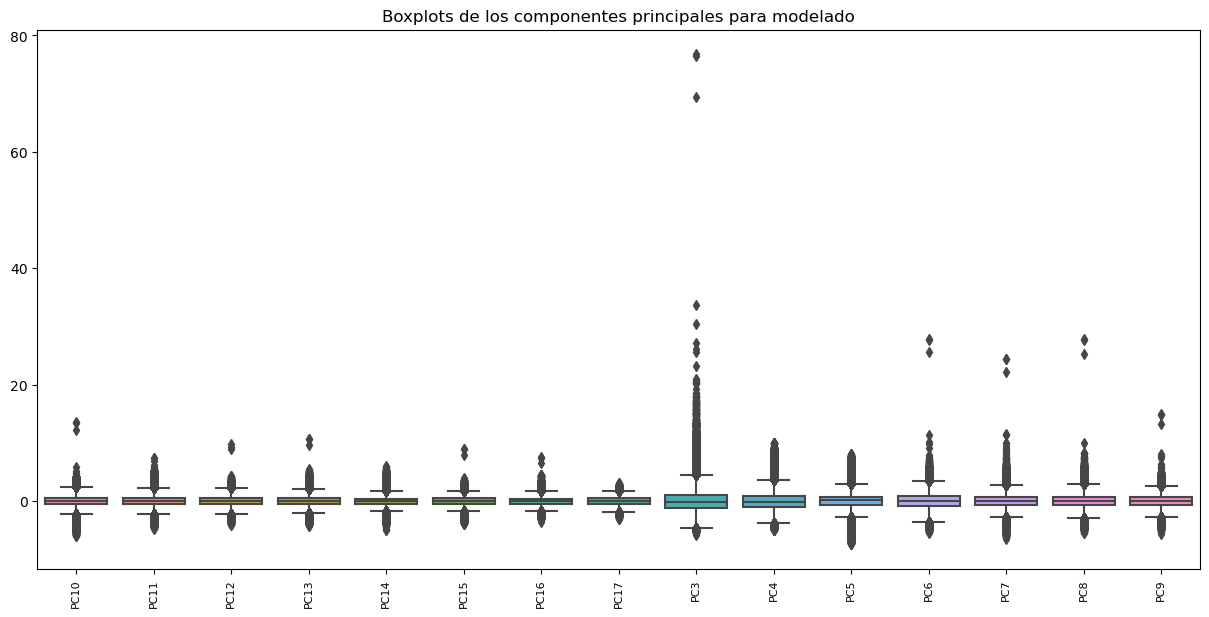

In [79]:
# Revisamos la distribución de los componentes principales seleccionados:
plt.figure(figsize=(15, 7))
sns.boxplot(X_scaled)
plt.xticks(fontsize=8, rotation=90)
plt.title('Boxplots de los componentes principales para modelado')
plt.show()

5. Las redes neuronales, caso LSTM, requieren datos escalados. Ya que las variables características fueron escaladas previamente, escalamos la variable objetivo. También, aplicamos transfomación **Yeo-Johnson** sobre esta, lo cual aceleró la convergencia del modelo durante los experimentos.

In [80]:
from sklearn.preprocessing import RobustScaler
from scipy.stats import yeojohnson

# Transformación Yeo-Johnson sobre la variable objetivo. 
yj_Y, lambda_best_fit = yeojohnson(Y)

# Escalar las variables objetivo
Y = pd.DataFrame(yj_Y, index=Y.index)
Y_scaler = RobustScaler()
Y_scaled = Y_scaler.fit_transform(Y)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns, index=Y.index)

6. Para que el modelo pueda capturar patrones intra día y hora de los datos, agregamos variables dummy de día (7 variables) y hora (24 variables).

In [ ]:
# One-hot encoding para el día de la semana:
days_encoded = pd.get_dummies(X_scaled.index.dayofweek, prefix='day')

# One-hot encoding para la hora del día:
hours_encoded = pd.get_dummies(X_scaled.index.hour, prefix='hour')

# Asegurarse de que los DataFrames codificados tengan el mismo índice que X_scaled:
days_encoded.index = X_scaled.index
hours_encoded.index = X_scaled.index

# Concatenar las columnas codificadas al DataFrame original
X_scaled = pd.concat([X_scaled, days_encoded, hours_encoded], axis=1)
X_scaled = X_scaled.astype('float32')

# Eliminar variables de día y hora de referencia (lunes y hora 0, respectivamente):
X_scaled.drop(columns=['hour_0', 'day_0'], inplace=True)

7. Dividimos los datos en conjuntos de entrenamiento, validación y prueba, respetando la temporalidad.

In [ ]:
# Dividir los datos en entrenamiento y prueba:
train_size = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
Y_train, Y_test = Y_scaled[:train_size], Y_scaled[train_size:]

# Invertir el escalado de los datos de prueba a escala original:
Y_test_rescaled = Y_scaler.inverse_transform(Y_test)

# Dividir el conjunto de entrenamiento en entrenamiento (80% de train_size) y validación (20% de train_size)
val_size = int(train_size * 0.7)
X_train, X_val = X_train[:val_size], X_train[val_size:]
Y_train, Y_val = Y_train[:val_size], Y_train[val_size:]

# Cambiar la forma de los datos para LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Definir la cantidad de nodos de entrada y de salida:
window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_scaled.shape[1]

8. Revisamos la densidad de distribución de los subconjuntos de la variable objetivo. Diferencias significativas en las distribuciones de `Y_train`, `Y_val` y `Y_test` pueden llevar a problemas de predicción sobre los conjuntos de validación y evaluación. 

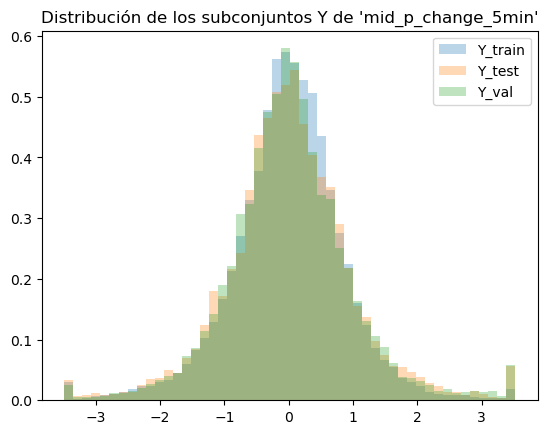

In [34]:
# Visualizar  distribución de variable objetivo:
plt.hist(Y_train, alpha=0.3, density=True, label="Y_train", bins=50)
plt.hist(Y_test, alpha=0.3, density=True, label="Y_test", bins=50)
plt.hist(Y_val, alpha=0.3, density=True, label="Y_val", bins=50)
plt.title(f"Distribución de los subconjuntos Y de '{target_var}'")
plt.legend()
plt.show()

In [35]:
from scipy.stats import ks_2samp

# 2. Prueba de Kolmogorov-Smirnov para comparar las distribuciones
ks_statistic_train_test, ks_pvalue_train_test = ks_2samp(Y_train.values.ravel(), Y_test.values.ravel())
ks_statistic_train_val, ks_pvalue_train_val = ks_2samp(Y_train.values.ravel(), Y_val.values.ravel())
ks_statistic_test_val, ks_pvalue_test_val = ks_2samp(Y_test.values.ravel(), Y_val.values.ravel())

print(f"Prueba KS entre Y_train y Y_test: Estadístico = {ks_statistic_train_test:.4f}, p-valor = {ks_pvalue_train_test:.4f}")
print(f"Prueba KS entre Y_train y Y_val: Estadístico = {ks_statistic_train_val:.4f}, p-valor = {ks_pvalue_train_val:.4f}")
print(f"Prueba KS entre Y_test y Y_val: Estadístico = {ks_statistic_test_val:.4f}, p-valor = {ks_pvalue_test_val:.4f}")

Prueba KS entre Y_train y Y_test: Estadístico = 0.0286, p-valor = 0.0000
Prueba KS entre Y_train y Y_val: Estadístico = 0.0262, p-valor = 0.0000
Prueba KS entre Y_test y Y_val: Estadístico = 0.0132, p-valor = 0.0000


9. Diseño de la arquitectura de la red LSTM y ajuste de hiperparámetros.

In [36]:
# Tasa de aprendizaje inicial:
initial_lr = 0.001

# Constante que determina la rapidez de decaimiento de initial_lr:
k = 0.001 # [0.001, 0.005, 0.01, 0.015, 0.02]

# Dropout generalizado:
dropout = 0.1

# Tasa de regularización L2:
l2_rate = 0.05

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.regularizers import l2

# Iniciar la red secuencial:
lstm_model = Sequential()

# Primera capa LSTM:
lstm_model.add( # Bidirectional(
     LSTM(60,
          activation='tanh', 
          input_shape=(window_size, n_features),
          dropout=dropout,
          recurrent_dropout=dropout,
          kernel_regularizer=l2(l2_rate), # Subir o bajar incrementa o disminuye el MSE de train y val, pero no disminuye la brecha
          recurrent_regularizer=l2(l2_rate),
          return_sequences=True  # Esto permite que la salida sea una secuencia, que alimentará la siguiente capa LSTM.
          )
     ) # )

# Capa de dropout previa a la capa densa:
lstm_model.add(Dropout(dropout))

# Segunda capa LSTM:
lstm_model.add( # Bidirectional(
     LSTM(50,
          activation='tanh',
          dropout=dropout,
          recurrent_dropout=dropout
          )
     ) # )

# # Capa de dropout previa a la capa densa:
# lstm_model.add(Dropout(dropout)) # <-- esto es raro, no debería estar aquí 

# Capa densa de salida:
lstm_model.add(Dense(n_outputs))

# Compilar el modelo:
optimizer = Adam(learning_rate=initial_lr)
lstm_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_squared_error'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import math

# Definir EarlyStopping:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0005,
    verbose=1,
    restore_best_weights=True
    )

# Definir el checkpoint del modelo:
checkpoint = ModelCheckpoint(
    'trained_models/best_model.h5',
    monitor='val_loss',
    save_best_only=True
    )

# Definir el LearningRateScheduler:
def exponential_decay(epoch, initial_lr=initial_lr, k=k):
    new_lr = initial_lr * math.exp(-k * epoch)
    return new_lr

lr_scheduler = LearningRateScheduler(exponential_decay)

# Entrenamiento del modelo:
train_history = lstm_model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=72,
    validation_data=(X_val, Y_val),
    verbose=2,
    shuffle=False,
    callbacks=[early_stopper, checkpoint, lr_scheduler]
    )

In [ ]:
import json

# Guardar el modelo completo en formato HDF5:
lstm_model.save('trained_models/lstm_model_pca_5m.h5')

# # Guardar la historia como JSON:
# with open('trained_models/train_history_1.json', 'w') as file:
#     json.dump(train_history.history, file)

In [ ]:
import json

# Cargar modelo guardado:
lstm_model = load_model('trained_models/lstm_model_pca_5m.h5')

# # Cargar la historia desde JSON:
# with open('trained_models/lstm_model_pca_5m.json', 'r') as file:
#     train_history = json.load(file)

In [ ]:
# # Continuar entrenamiento del modelo:
# train_history = lstm_model.fit(
#     X_train,
#     Y_train,
#     epochs=40,
#     batch_size=72,
#     validation_data=(X_val, Y_val),
#     verbose=2,
#     shuffle=False,
#     callbacks=[checkpoint, lr_scheduler]
#     )

In [2]:
# Copiar los resultados del entrenamiento:
train_history = {
    "epoch": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "loss": [0.5713, 0.5429, 0.5405, 0.5400, 0.5394, 0.5381, 0.5362, 0.5347, 0.5336, 0.5323, 0.5313, 0.5301, 0.5288, 0.5280, 0.5276, 0.5267, 0.5258, 0.5249, 0.5242, 0.5231],
    "mean_squared_error": [0.5134, 0.4983, 0.4973, 0.4973, 0.4960, 0.4931, 0.4896, 0.4861, 0.4842, 0.4817, 0.4797, 0.4782, 0.4758, 0.4746, 0.4742, 0.4726, 0.4717, 0.4707, 0.4700, 0.4683],
    "val_loss": [0.5530, 0.5499, 0.5501, 0.5500, 0.5509, 0.5479, 0.5463, 0.5453, 0.5438, 0.5428, 0.5431, 0.5432, 0.5426, 0.5407, 0.5420, 0.5415, 0.5411, 0.5404, 0.5403, 0.5403],
    "val_mean_squared_error": [0.5440, 0.5499, 0.5514, 0.5505, 0.5510, 0.5431, 0.5386, 0.5359, 0.5325, 0.5313, 0.5325, 0.5330, 0.5313, 0.5295, 0.5323, 0.5318, 0.5318, 0.5313, 0.5314, 0.5322],
    "lr": [0.0010, 0.000999, 0.000997, 0.000994, 0.000990, 0.000985, 0.000979, 0.000972, 0.000965, 0.000956, 0.000946, 0.000936, 0.000925, 0.000913, 0.000900, 0.000887, 0.000873, 0.000858, 0.000843, 0.000827]
    }

10. Evaluación del modelo.

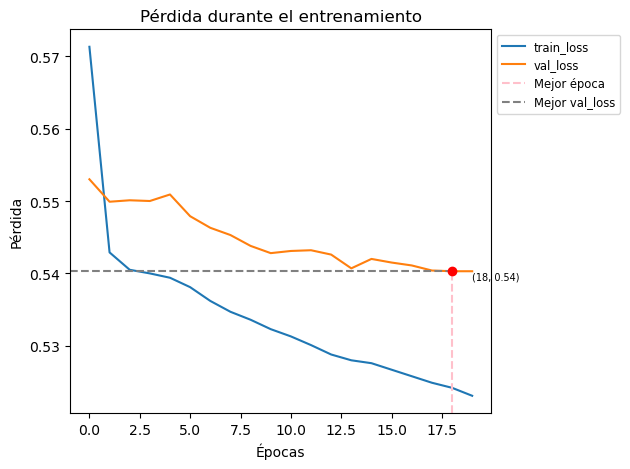

In [ ]:
train_history_df = pd.DataFrame(train_history)

# Plotear los resultados del entrenamiento:
plt.plot(train_history_df['loss'], label='train_loss')
plt.plot(train_history_df['val_loss'], label='val_loss')

# Obtener el índice (época) del mejor valor de pérdida de validación
best_epoch = train_history_df['val_loss'].idxmin()
best_loss = train_history_df['val_loss'].min()

# Agregar líneas punteadas a la coordenada de mejores época y val_loss 
y_ratio = best_loss / plt.ylim()[1]
plt.axvline(x=best_epoch, color='pink', linestyle='--',
            ymax=(best_loss - plt.ylim()[0]) / (plt.ylim()[1] - plt.ylim()[0]), label='Mejor época')
plt.axhline(y=best_loss, color='gray', linestyle='--', xmax=best_epoch/plt.xlim()[1], label='Mejor val_loss')
plt.plot(best_epoch, best_loss, 'ro')

# Mostrar los valores de mejor época y mejor pérdida como coordenadas
plt.text(best_epoch + 1, best_loss, f'({best_epoch}, {best_loss:.2f})',
         color='black', verticalalignment='top', horizontalalignment='left', fontsize=7)

plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Hacer predicciones
Y_pred = lstm_model.predict(X_test)

# Invertir el escalado para obtener las predicciones en la escala original:
Y_pred_rescaled = Y_scaler.inverse_transform(Y_pred)

17115/17115 [==============================] - 36s 2ms/step


In [ ]:
# Métricas de evaluación:
evaluation_metrics = lstm_model.evaluate(X_test, Y_test)

# Obtener el MAE de entrenamiento y validación al final del entrenamiento
train_mae = train_history.history['loss'][-1]
val_mae = train_history.history['val_loss'][-1]
test_mae = evaluation_metrics[0]

print("MAE entrenamiento: ", round(train_mae, 3))
print("MAE validación: ", round(val_mae, 3))
print("MAE evaluación:", round(test_mae, 3))

# Proporciones sobre entrenamiento:
print("\n")
print("Proporción MAE entrenamiento: ", round(train_mae / train_mae, 3))
print("Proporción MAE validación: ", round(val_mae / train_mae, 3))
print("Proporción MAE evaluación:", round(test_mae / train_mae, 3))

17115/17115 [==============================] - 40s 2ms/step - loss: 0.5459 - mean_squared_error: 0.5382
MAE entrenamiento:  0.523
MAE validación:  0.54
MAE evaluación: 0.546


Proporción MAE entrenamiento:  1.0
Proporción MAE validación:  1.033
Proporción MAE evaluación: 1.043


In [ ]:
# Obtener el RMSE de entrenamiento y validación al final del entrenamiento
train_rmse = train_history.history['mean_squared_error'][-1]**(1/2)
val_rmse = train_history.history['val_mean_squared_error'][-1] **(1/2)
test_rmse = evaluation_metrics[1] **(1/2)

print("RMSE entrenamiento: ", round(train_rmse, 3))
print("RMSE validación: ", round(val_rmse, 3))
print("RMSE evaluación:", round(test_rmse, 3))

# Proporciones sobre entrenamiento:
print("\n")
print("Proporción RMSE entrenamiento: ", round(train_rmse / train_rmse, 3))
print("Proporción RMSE validación: ", round(val_rmse / train_rmse, 3))
print("Proporción RMSE evaluación:", round(test_rmse / train_rmse, 3))

RMSE entrenamiento:  0.684
RMSE validación:  0.73
RMSE evaluación: 0.734


Proporción RMSE entrenamiento:  1.0
Proporción RMSE validación:  1.066
Proporción RMSE evaluación: 1.072


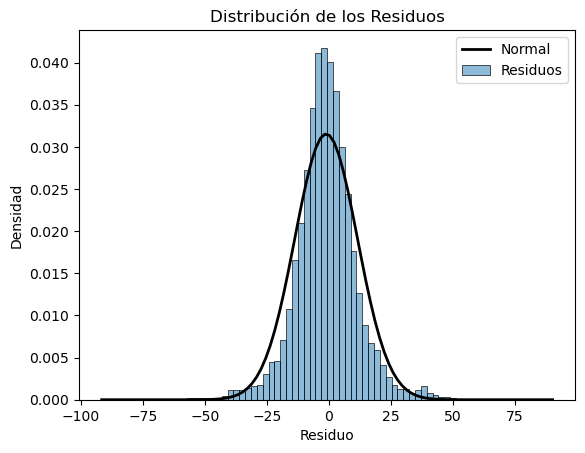

In [ ]:
from scipy.stats import norm

# Calcular los residuos
resid = Y_test_rescaled - Y_pred_rescaled

# Crear un histograma de los residuos
sns.histplot(resid, kde=False, stat='density', bins=70, label='Residuos')

# Crear una curva de distribución normal con la misma media y desviación estándar
mu, std = np.mean(resid), np.std(resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal')

# Título y etiquetas
plt.title("Distribución de los Residuos")
plt.xlabel("Residuo")
plt.ylabel("Densidad")
plt.legend()
plt.show()

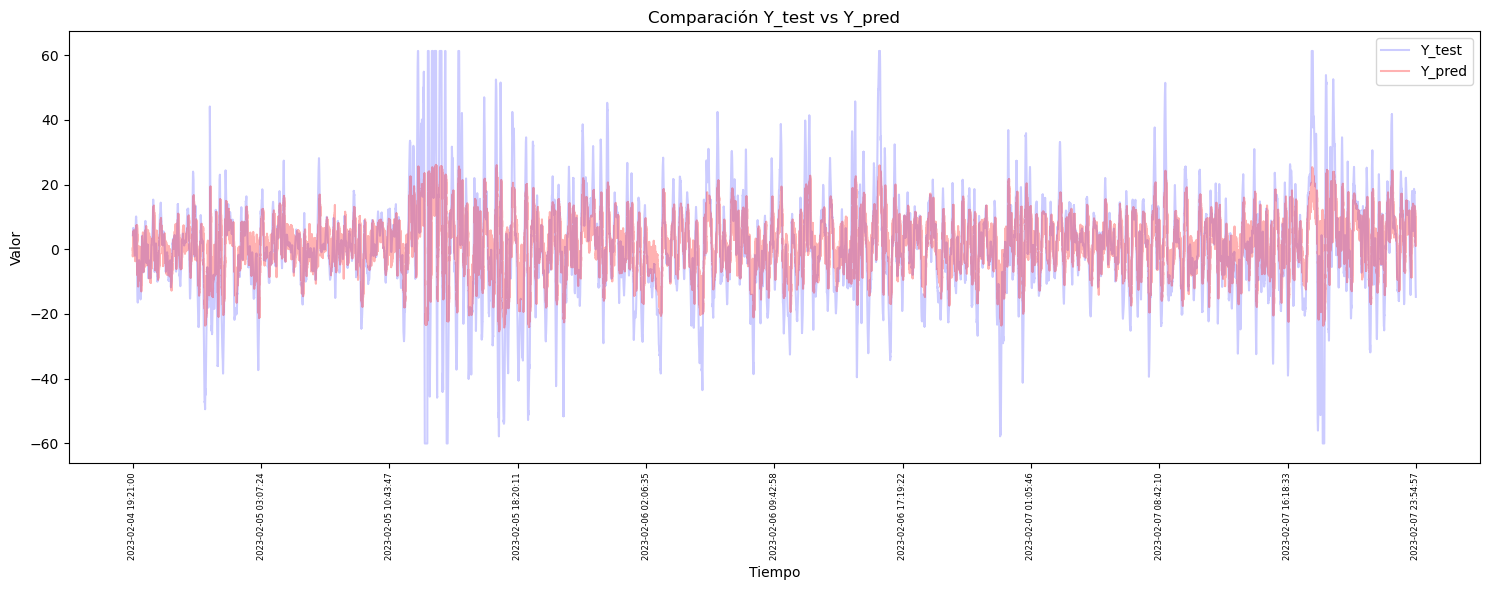

In [ ]:
plt.figure(figsize=(15, 6))

# Graficar los valores reales
plt.plot(Y_test_rescaled, label='Y_test', color='blue', alpha=0.2)

# Graficar las predicciones
plt.plot(Y_pred_rescaled, label='Y_pred', color='red', alpha=0.3)

# Definir el título y las etiquetas del gráfico
plt.title('Comparación Y_test vs Y_pred')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Establecer las etiquetas del eje x usando el índice de tiempo de Y_test
time_labels = Y_test.index.to_list()
positions = list(range(0, len(Y_test_rescaled), len(Y_test_rescaled)//10))  # Tomar 10 puntos equidistantes para las etiquetas
selected_labels = [time_labels[i].strftime('%Y-%m-%d %H:%M:%S') for i in positions]
plt.xticks(positions, selected_labels, rotation=90, size=6)

plt.legend()
plt.tight_layout()
plt.show()

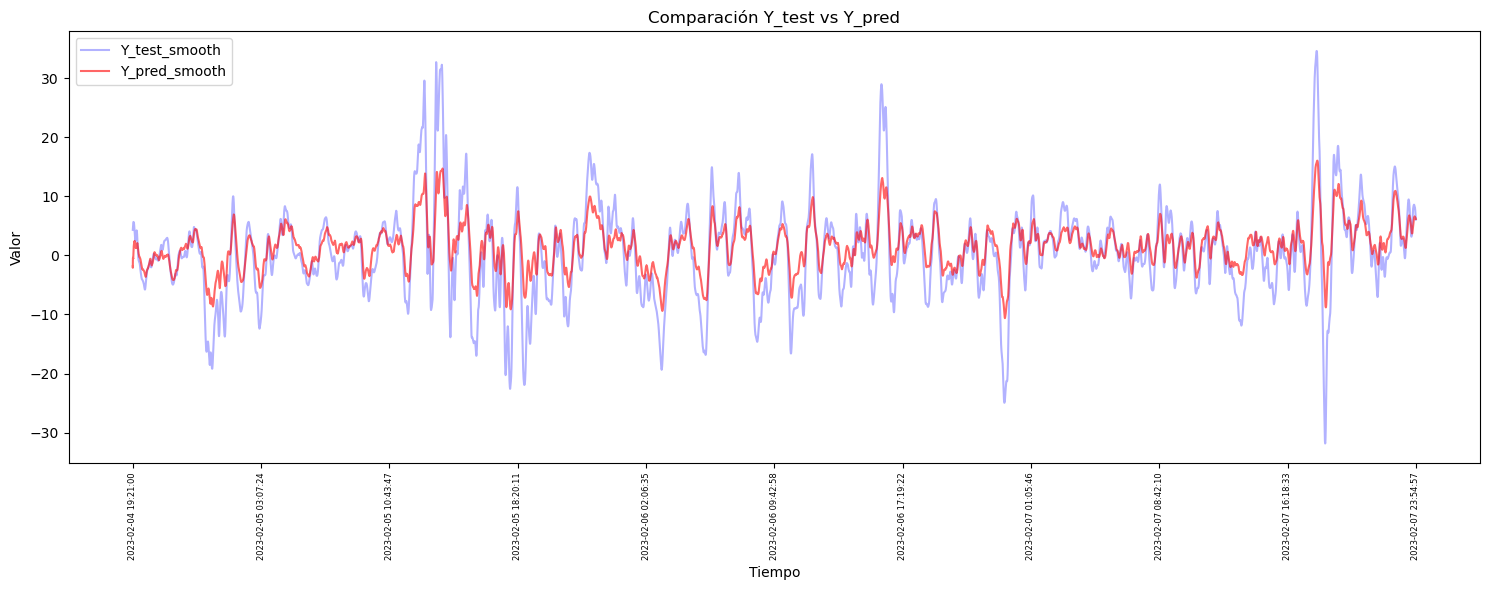

In [ ]:
# Convertir Y_test_rescaled y Y_pred_rescaled a Series de Pandas para facilidad de uso
Y_test_series = pd.Series(Y_test_rescaled.flatten())
Y_pred_series = pd.Series(Y_pred_rescaled.flatten())

# Calcular la media móvil
window_size = 3600  # Ajustar según tus necesidades
Y_test_smooth = Y_test_series.rolling(window=window_size, min_periods=1).mean()
Y_pred_smooth = Y_pred_series.rolling(window=window_size, min_periods=1).mean()

# Crear el gráfico
plt.figure(figsize=(15, 6))
plt.plot(Y_test_smooth, label='Y_test_smooth', color='blue', alpha=0.3)
plt.plot(Y_pred_smooth, label='Y_pred_smooth', color='red', alpha=0.6)

# Definir el título y las etiquetas del gráfico
plt.title('Comparación Y_test vs Y_pred')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Establecer las etiquetas del eje x usando el índice de tiempo de Y_test
time_labels = Y_test.index.to_list()
positions = list(range(0, len(Y_test_rescaled), len(Y_test_rescaled)//10))  # Tomar 10 puntos equidistantes para las etiquetas
selected_labels = [time_labels[i].strftime('%Y-%m-%d %H:%M:%S') for i in positions]
plt.xticks(positions, selected_labels, rotation=90, size=6)

plt.legend()
plt.tight_layout()
plt.show()


# **2. Modelo con selección de características mediante Random Forest**

A continuación, un modelo predictivo de la variable `mid_p_change_5min` que alimenta la red neuronal LSTM con variables seleccionadas previamente por un modelo `RandomForestRegressor`. Este método de selección de variables, en comparación con otros métodos de selección lineales como las regresiones Lasso o Ridge, tiene la capacidad de identificar relaciones no lineales entre las variables.

1. Escalamos los datos don `sklearn.preprocessing.RobustScaler`.

In [ ]:
from sklearn.preprocessing import RobustScaler

# Escalar las variables características:
X_scaler = RobustScaler()
X_scaled = X_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Escalar la variable objetivo:
Y = Y.to_frame()
Y_scaler = RobustScaler()
Y_scaled = Y_scaler.fit_transform(Y)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns, index=Y.index)
# Y_scaled = Y_scaled[target_var]

# Muestrear datos:
sample_size = 100000
X_sample_scaled = X_scaled[:sample_size:]
Y_sample_scaled = Y_scaled[:sample_size:]

2) Ajustamos un modelo `sklearn.ensemble.RandomForestRegressor`, que incluye optimización de hiperparámetros mediante búsqueda aleatoria de grilla y validación cruzada.

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV

# # Búsqueda Aleatoria de hiperparámetros:
# random_grid = {
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['log2', 'sqrt']
#     }

# # Crear el modelo y el objeto RandomSearchCV:
# rf = RandomForestRegressor(n_estimators=50, n_jobs=-1)
# rf_random = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=random_grid,
#     n_iter=X_sample_scaled.shape[1],
#     cv=4,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
#     )

# # Ajustar el modelo:
# rf_random.fit(X_sample_scaled, Y_sample_scaled)

Fitting 4 folds for each of 46 candidates, totalling 184 fits


RandomizedSearchCV(cv=4,
                   estimator=RandomForestRegressor(n_estimators=50, n_jobs=-1),
                   n_iter=46, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=2)

In [ ]:
# # Obtener el mejor modelo:
# best_rf = rf_random.best_estimator_

# # Obtén la importancia de las características:
# feature_importances = best_rf.feature_importances_

# features_df = pd.DataFrame({
#     'Feature': X_sample_scaled.columns,
#     'Importance': feature_importances
# })

# features_df.to_csv('eda/features_df_data2.csv')

In [ ]:
# Cargar tabla de selección de características:
features_df = pd.read_csv('eda/features_df_data2.csv')
features_df.set_index('Feature').drop(columns=['Unnamed: 0'], inplace=True)

# Ordenar el DataFrame basado en la importancia de las características
features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Revisamos las variables seleccionadas por el modelo:
features_df

0.8568618572340441

In [63]:
RF_X = X_scaled[features_df['Feature'].values]

# Obtener las variables características regularizadas con una constante:
const_RF_X = sm.add_constant(RF_X)

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(Y_scaled, const_RF_X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      mid_p_change_5min   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                 1.078e+05
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:57:18   Log-Likelihood:            -2.6319e+06
No. Observations:             2738376   AIC:                         5.264e+06
Df Residuals:                 2738360   BIC:                         5.264e+06
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [65]:
# Dividir los datos en entrenamiento y prueba:
train_size = int(len(RF_X) * 0.8)

X_train, X_test = RF_X[:train_size], RF_X[train_size:]
Y_train, Y_test = Y_scaled[:train_size], Y_scaled[train_size:]

# Invertir el escalado de los datos de prueba a escala original:
Y_test_rescaled = Y_scaler.inverse_transform(Y_test)

# Dividir el conjunto de entrenamiento en entrenamiento (80% de train_size) y validación (20% de train_size)
val_size = int(train_size * 0.7)
X_train, X_val = X_train[:val_size], X_train[val_size:]
Y_train, Y_val = Y_train[:val_size], Y_train[val_size:]

# Cambiar la forma de los datos para LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Definir la cantidad de nodos de entrada y de salida:
window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_scaled.shape[1]

In [40]:
# Tasa de aprendizaje inicial:
initial_lr = 0.001

# Constante que determina la rapidez de decaimiento de initial_lr:
k = 0.001 # [0.001, 0.005, 0.01, 0.015, 0.02]

# Dropout generalizado:
dropout = 0.1

# Tasa de regularización L2:
l2_rate = 0.05

In [69]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.regularizers import l2

# Iniciar la red secuencial:
lstm_model_2 = Sequential()

# Primera capa LSTM:
lstm_model_2.add( # Bidirectional(
     LSTM(60,
          activation='tanh', 
          input_shape=(window_size, n_features),
          dropout=dropout,
          recurrent_dropout=dropout,
          kernel_regularizer=l2(l2_rate), # Subir o bajar incrementa o disminuye el MSE de train y val, pero no disminuye la brecha
          recurrent_regularizer=l2(l2_rate),
          return_sequences=True  # Esto permite que la salida sea una secuencia, que alimentará la siguiente capa LSTM.
          )
     ) # )

# Capa de dropout previa a la capa densa:
lstm_model_2.add(Dropout(dropout))

# Segunda capa LSTM:
lstm_model_2.add( # Bidirectional(
     LSTM(50,
          activation='tanh',
          dropout=dropout,
          recurrent_dropout=dropout
          )
     ) # )

# # Capa de dropout previa a la capa densa:
# lstm_model_2.add(Dropout(dropout)) # <-- esto es raro, no debería estar aquí 

# Capa densa de salida:
lstm_model_2.add(Dense(n_outputs))

# Compilar el modelo:
optimizer = Adam(learning_rate=initial_lr)
lstm_model_2.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_squared_error'])

In [70]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import math

# Definir EarlyStopping:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0005,
    verbose=1,
    restore_best_weights=True
    )

# Definir el checkpoint del modelo:
checkpoint = ModelCheckpoint(
    'trained_models/best_model_2.h5',
    monitor='val_loss',
    save_best_only=True
    )

# Definir el LearningRateScheduler:
def exponential_decay(epoch, initial_lr=initial_lr, k=k):
    new_lr = initial_lr * math.exp(-k * epoch)
    return new_lr

lr_scheduler = LearningRateScheduler(exponential_decay)

# Entrenamiento del modelo:
train_history_2 = lstm_model_2.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=72,
    validation_data=(X_val, Y_val),
    verbose=2,
    shuffle=False,
    callbacks=[early_stopper, checkpoint, lr_scheduler]
    )

Epoch 1/20
21299/21299 - 141s - loss: 0.5640 - mean_squared_error: 0.5393 - val_loss: 0.5711 - val_mean_squared_error: 0.5770 - lr: 0.0010 - 141s/epoch - 7ms/step
Epoch 2/20
21299/21299 - 145s - loss: 0.5360 - mean_squared_error: 0.5181 - val_loss: 0.5619 - val_mean_squared_error: 0.5703 - lr: 9.9900e-04 - 145s/epoch - 7ms/step
Epoch 3/20
21299/21299 - 146s - loss: 0.5328 - mean_squared_error: 0.5138 - val_loss: 0.5611 - val_mean_squared_error: 0.5701 - lr: 9.9700e-04 - 146s/epoch - 7ms/step
Epoch 4/20
21299/21299 - 147s - loss: 0.5321 - mean_squared_error: 0.5133 - val_loss: 0.5599 - val_mean_squared_error: 0.5651 - lr: 9.9402e-04 - 147s/epoch - 7ms/step
Epoch 5/20
21299/21299 - 146s - loss: 0.5310 - mean_squared_error: 0.5093 - val_loss: 0.5603 - val_mean_squared_error: 0.5647 - lr: 9.9005e-04 - 146s/epoch - 7ms/step
Epoch 6/20
21299/21299 - 147s - loss: 0.5288 - mean_squared_error: 0.5030 - val_loss: 0.5578 - val_mean_squared_error: 0.5612 - lr: 9.8511e-04 - 147s/epoch - 7ms/step
Ep

In [85]:
# Guardar el modelo completo en formato HDF5:
lstm_model_2.save('trained_models/lstm_model_rf_5m.h5')

# Cargar modelo guardado:
lstm_model_2 = load_model('trained_models/lstm_model_rf_5m.h5')

In [4]:
# Copiar los resultados del entrenamiento:
train_history_2 = {
    "epoch": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'loss': [0.5639941692352295, 0.5359649658203125, 0.532798171043396, 0.5320594906806946, 0.5309514403343201, 0.5288159251213074, 0.5262802243232727, 0.5240222811698914, 0.5229149460792542, 0.5217072367668152, 0.5205308198928833, 0.5188451409339905, 0.5174069404602051, 0.5169092416763306, 0.5165029168128967, 0.5157865881919861, 0.5149596929550171, 0.5143263339996338, 0.5133349299430847, 0.5127431750297546], 
    'mean_squared_error': [0.539295494556427, 0.5180509686470032, 0.5137604475021362, 0.5132924914360046, 0.5093051791191101, 0.5030246376991272, 0.49646276235580444, 0.492876797914505, 0.49099329113960266, 0.48928335309028625, 0.48788249492645264, 0.4866897463798523, 0.4846794009208679, 0.48376575112342834, 0.4831298291683197, 0.4820649027824402, 0.48105886578559875, 0.47996196150779724, 0.4781951308250427, 0.4770703613758087], 
    'val_loss': [0.5710650682449341, 0.5618805885314941, 0.5610937476158142, 0.5599432587623596, 0.5603058338165283, 0.5578107833862305, 0.5562069416046143, 0.5573228597640991, 0.5517269968986511, 0.5548851490020752, 0.5504768490791321, 0.5465658903121948, 0.5450618267059326, 0.5443912744522095, 0.5455188155174255, 0.5441252589225769, 0.5457812547683716, 0.5434613823890686, 0.5434694886207581, 0.5437183976173401], 
    'val_mean_squared_error': [0.5770415663719177, 0.5703026056289673, 0.570090115070343, 0.5650966167449951, 0.5647042393684387, 0.561167299747467, 0.5555201768875122, 0.5610526204109192, 0.5507312417030334, 0.558362603187561, 0.5536871552467346, 0.5533124804496765, 0.5493976473808289, 0.5487557053565979, 0.5524072647094727, 0.5514401793479919, 0.5543578863143921, 0.5524385571479797, 0.552591860294342, 0.5527732968330383], 
    'lr': [0.001, 0.0009990005, 0.0009970044, 0.0009940179, 0.0009900498, 0.0009851119, 0.000979219, 0.00097238837, 0.0009646403, 0.0009559975, 0.00094648515, 0.0009361309, 0.00092496444, 0.0009130177, 0.00090032455, 0.0008869205, 0.0008728427, 0.00085812976, 0.0008428216, 0.00082695915]
    }

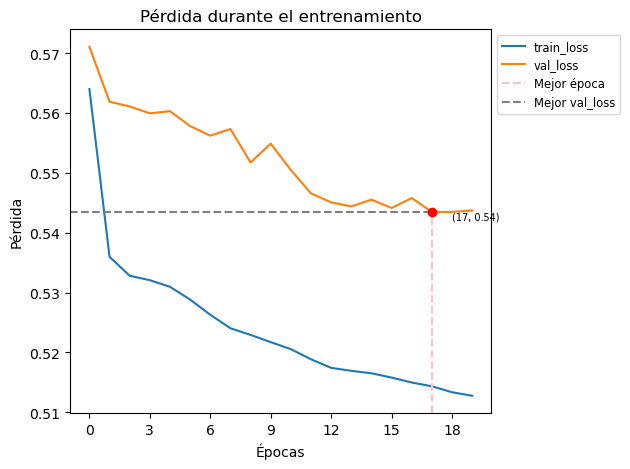

In [84]:
from matplotlib.ticker import MaxNLocator

train_history_df = pd.DataFrame(train_history_2)

# Plotear los resultados del entrenamiento:
plt.plot(train_history_df['loss'], label='train_loss')
plt.plot(train_history_df['val_loss'], label='val_loss')

# Obtener el índice (época) del mejor valor de pérdida de validación
best_epoch = train_history_df['val_loss'].idxmin()
best_loss = train_history_df['val_loss'].min()

# Agregar líneas punteadas a la coordenada de mejores época y val_loss 
y_ratio = best_loss / plt.ylim()[1]
plt.axvline(x=best_epoch, color='pink', linestyle='--',
            ymax=(best_loss - plt.ylim()[0]) / (plt.ylim()[1] - plt.ylim()[0]), label='Mejor época')
plt.axhline(y=best_loss, color='gray', linestyle='--', xmax=best_epoch/plt.xlim()[1], label='Mejor val_loss')
plt.plot(best_epoch, best_loss, 'ro')

# Mostrar los valores de mejor época y mejor pérdida como coordenadas
plt.text(best_epoch + 1, best_loss, f'({best_epoch}, {best_loss:.2f})',
         color='black', verticalalignment='top', horizontalalignment='left', fontsize=7)

plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Configurar el eje x para que solo tenga valores enteros
ax = plt.gca()  # Obtener el objeto del eje actual
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [73]:
# Métricas de evaluación:
evaluation_metrics = lstm_model_2.evaluate(X_test, Y_test)

# Obtener el MAE de entrenamiento y validación al final del entrenamiento
train_mae = train_history_2.history['loss'][-1]
val_mae = train_history_2.history['val_loss'][-1]
test_mae = evaluation_metrics[0]

print("MAE entrenamiento: ", round(train_mae, 3))
print("MAE validación: ", round(val_mae, 3))
print("MAE evaluación:", round(test_mae, 3))

# Proporciones sobre entrenamiento:
print("\n")
print("Proporción MAE entrenamiento: ", round(train_mae / train_mae, 3))
print("Proporción MAE validación: ", round(val_mae / train_mae, 3))
print("Proporción MAE evaluación:", round(test_mae / train_mae, 3))

17115/17115 [==============================] - 34s 2ms/step - loss: 0.5517 - mean_squared_error: 0.5577
MAE entrenamiento:  0.513
MAE validación:  0.544
MAE evaluación: 0.552


Proporción MAE entrenamiento:  1.0
Proporción MAE validación:  1.06
Proporción MAE evaluación: 1.076


In [71]:
# Hacer predicciones
Y_pred = lstm_model_2.predict(X_test)

# Invertir el escalado para obtener las predicciones en la escala original:
Y_pred_rescaled = Y_scaler.inverse_transform(Y_pred)

17115/17115 [==============================] - 32s 2ms/step


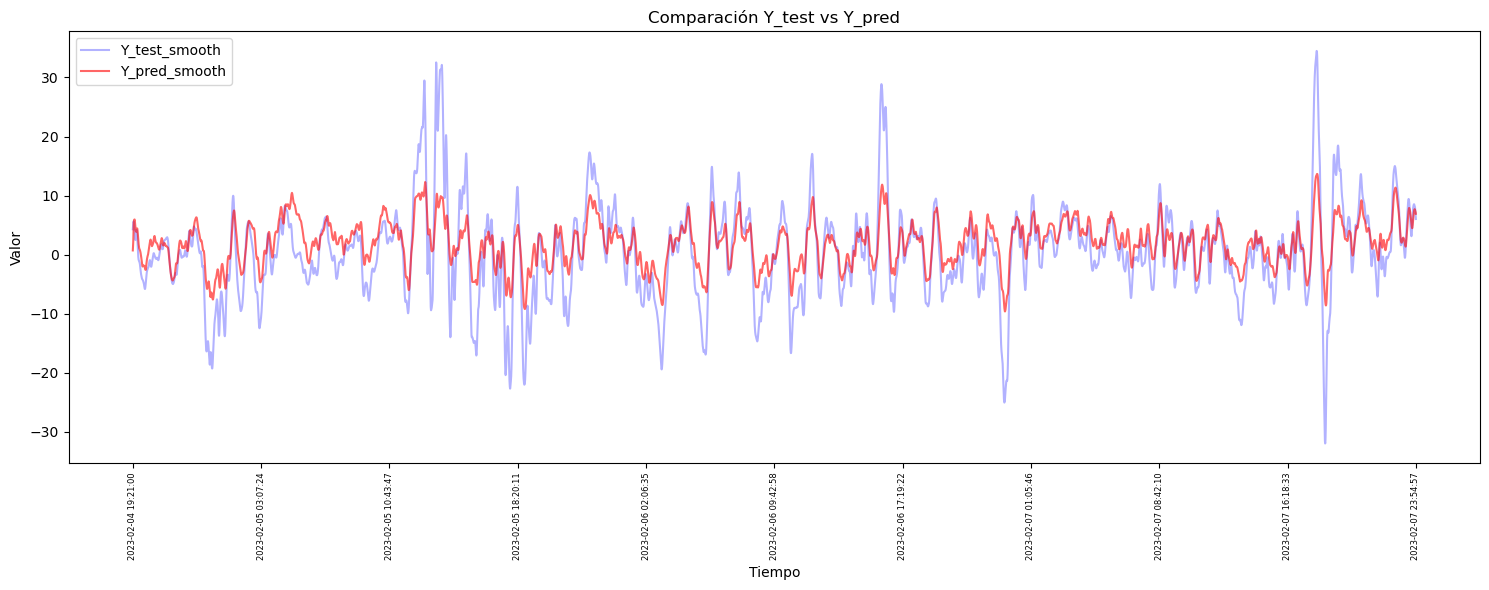

In [72]:
# Convertir Y_test_rescaled y Y_pred_rescaled a Series de Pandas para facilidad de uso
Y_test_series = pd.Series(Y_test_rescaled.flatten())
Y_pred_series = pd.Series(Y_pred_rescaled.flatten())

# Calcular la media móvil
window_size = 3600
Y_test_smooth = Y_test_series.rolling(window=window_size, min_periods=1).mean()
Y_pred_smooth = Y_pred_series.rolling(window=window_size, min_periods=1).mean()

# Crear el gráfico
plt.figure(figsize=(15, 6))
plt.plot(Y_test_smooth, label='Y_test_smooth', color='blue', alpha=0.3)
plt.plot(Y_pred_smooth, label='Y_pred_smooth', color='red', alpha=0.6)

# Definir el título y las etiquetas del gráfico
plt.title('Comparación Y_test vs Y_pred')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Establecer las etiquetas del eje x usando el índice de tiempo de Y_test
time_labels = Y_test.index.to_list()
positions = list(range(0, len(Y_test_rescaled), len(Y_test_rescaled)//10))  # Tomar 10 puntos equidistantes para las etiquetas
selected_labels = [time_labels[i].strftime('%Y-%m-%d %H:%M:%S') for i in positions]
plt.xticks(positions, selected_labels, rotation=90, size=6)

plt.legend()
plt.tight_layout()
plt.show()
